In [1]:
pip install biopython

  Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (12 kB)
Using cached biopython-1.84-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.2 MB)
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pygraphviz

  Using cached pygraphviz-1.13-cp311-cp311-linux_x86_64.whl
Note: you may need to restart the kernel to use updated packages.


In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
from Bio import Align
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.preprocessing import MinMaxScaler
import re
import os
import copy
import pickle
import gzip
import math
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import pygraphviz
import datetime
import statistics
from matplotlib_venn import venn3
#stats
from scipy.signal import find_peaks
from itertools import combinations#
from itertools import combinations_with_replacement
from scipy.stats import linregress
date = datetime.datetime.now().strftime("%Y-%m-%d")
from scipy.stats import ttest_ind
from scipy.stats import chisquare
from scipy.stats import binomtest
from scipy.stats import ttest_rel
#from colorspacious import cspace_converter

In [4]:
#####
#output all dictionaries
to_plot=['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB','ND3_v1','ND3_v2','ND7', 'ND8', 'ND9', 'RPS12']
def pickle_out(var,outfile):
    out,errors,names=[],[],[]
    with gzip.open('tmp', 'wb') as f:
        for k in var:
            if type(var[k]) is dict and not k.startswith('_'):
                try:
                    pickle.dump(var[k], f)
                    out.append(var[k])
                    names.append(k)
                    print(f'dump {k}')
                except:
                    errors.append(f"{k} failed")
    print(errors)
    f.close()
    names.append('save')
    out.append(names)
    with gzip.open(outfile, 'wb') as f:
        pickle.dump(out, f)
    f.close()
    print(len(out))
    
def pickle_load(file,prefix):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        out=pickle.load(f)
    print([f"{prefix}_{i}"  for i in out[-1]])
    return out
##

#####
def get_gRNA_info (txt,adjust=0): #build dictionary from gRNA_with_expression files
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        gRNA_dict={f'gRNA_{i}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}for i,line in enumerate(handle)}
        for key in gRNA_dict:
            init_site=int(gRNA_dict[key]['mRNA_end'])+int(gRNA_dict[key]['rel_pos'])
            if gRNA_dict[key]['mRNA_name'] not in ['CYB','MURF2']:
                gRNA_dict[key]['gene_mRNA_end']=init_site+adjust
            else:
                gRNA_dict[key]['gene_mRNA_end']=init_site
    return(gRNA_dict)  
#get deletion and editing seuqences
def read_editing_sites(small_u):
    smallu=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    edits={}
    for k in smallu:
        sites=[0 if b=='u' else 1 for b in smallu[k].seq] #0 for insertions
        edits[k]=sites
    return(edits)
#deletion
def read_deletion_sites(deletion):
    deletion=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    delets={}
    for k in deletion:
        sites=[0 if b!='-' else 1 for b in deletion[k].seq] #0 for deletion sites
        delets[k]=sites
    return(delets)
#
#initiation site counts
def initiation_site_counts(gRNA_dict,small_u):
    insertions=read_editing_sites(small_u)
    mrna0={k:[0]*(len(insertions[k])+100) for k in insertions} #extend the mRNA a bit longer for the initiation sites
    anchors={k:[0]*(len(insertions[k])+100) for k in insertions}
    fullanc={k:[0]*(len(insertions[k])+100) for k in insertions}
    for k in gRNA_dict:
        if gRNA_dict[k]['mRNA_name'] in ['ND8_PacBio','CYB_short']:
            continue
        else:
            init_site=gRNA_dict[k]['gene_mRNA_end']
            anc=int(gRNA_dict[k]['mRNA_end'])-int(gRNA_dict[k]['anchor_len'])
            mrna0[gRNA_dict[k]['mRNA_name']][init_site]+=1
            anchors[gRNA_dict[k]['mRNA_name']][anc]+=1
            for i in range(anc,int(gRNA_dict[k]['mRNA_end'])):
                fullanc[gRNA_dict[k]['mRNA_name']][i]+=1
    return(mrna0,anchors,fullanc)
#visualize the features
def slide_window_plot(inits,anchors,filename,ws=1,figw=100,figh=50):
    counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
    counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
    return(counts,counts_a)
def slide_window_plot_by_strain(strain_grna,small_u,insertions,file1,file2,ws=1,figw=100,figh=50):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue','EATRO1125':'orange'}
    fig,axs = plt.subplots(len(insertions),1,figsize=(figw,figh))
    for s in strain_grna:
        inits,anchors,fullanc=initiation_site_counts(strain_grna[s],small_u)
        counts={k:[sum(inits[k][i:i+ws]) for i in range(len(inits[k])-ws)] for k in inits} #find initiation sites with window
        counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
        c=0
        for k in insertions:
            ax=axs[c]
            ax.set_title(f'Initiation sites/anchor starts on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            ax.plot(range(len(counts[k])),counts[k],label=s,color=taxon_dict[s])
            #plot anchors
            ax.plot(range(len(counts_a[k])),np.array(counts_a[k])*(-1),color=taxon_dict[s])
    plt.legend()
    plt.savefig(file1)
    #plt.show()
    #draw full length anchors
    fig,axs = plt.subplots(len(insertions),1,figsize=(figw,figh))
    sum_anchor={k:np.array([0]*(len(counts[k])+1)) for k in counts_a}
    for s in strain_grna:
        inits,anchors,fullanc=initiation_site_counts(strain_grna[s],small_u)
        sum_anchor={k:sum_anchor[k]+np.array(v) for k,v in fullanc.items()}
        counts_a={k:[sum(anchors[k][i:i+ws]) for i in range(len(anchors[k])-ws)] for k in anchors} #find anchor starts with window
        c=0
        for k in insertions:
            ax=axs[c]
            ax.set_title(f'anchor starts/full-length anchor coverage on {k}, window size= {ws}',fontdict={'fontsize': 30, 'fontweight': 30})
            c+=1
            #plot init sites
            ax.plot(range(len(counts_a[k])),counts_a[k],label=s,color=taxon_dict[s],alpha=0.4)
            #plot anchors
            ax.plot(range(len(fullanc[k])),np.array(fullanc[k])*(-1),color=taxon_dict[s],alpha=0.4)
    for i,k in enumerate(insertions):
        ax=axs[i]
        ax.plot(range(len(sum_anchor[k])),np.array(sum_anchor[k])*(-1),label='SUM',color='k',alpha=0.4)
    plt.legend()
    plt.savefig(file2)
    plt.show()
    return(sum_anchor)
#define gRNA family boundaries
def anchor_clusters(counts):
    gRNA_families={}
    for k in counts:
        #find boundaries
        mrna=''.join([str(9) if i >9 else str(i) for i in counts[k]]) #one digit only real number count has 10 and can cause trouble
        starts=[match.start() for match in re.finditer('0{1,}',mrna)] #change from 3 to 1
        ends=[match.end() for match in re.finditer('0{1,}',mrna)]
        boundaries=[(i,j) for i,j in zip(ends[:-1],starts[1:])]
        gRNA_families[k]={f'{k}-{pair[0]}_{pair[1]}':{'bound':pair,'gRNA':[],'mRNA':k,'coverage':mrna[pair[0]:pair[1]]} for i,pair in enumerate(boundaries)}#','.join([str(i) for i in counts[k][pair[0]:pair[1]]])
        gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
        #print(gRNA_families)     
    total=sum([len(v) for v in gRNA_families.values()])
    print(f"identified {total} anchor clusters")
    return(gRNA_families)
#subdivision
def subdivision(gRNA_families,mrna,k,ds):#ds are pieces of the coverage string
    bound=gRNA_families[mrna][k]['bound']
    for d in ds:
        start=re.search(d,gRNA_families[mrna][k]['coverage']).start()+gRNA_families[mrna][k]['bound'][0]
        end=start+len(d)
        name=f"{mrna}-{start}_{end}"
        gRNA_families[mrna][name]={'bound':(start,end),'gRNA':[],'mRNA':mrna,'coverage':d}
        print(gRNA_families[mrna][name])
    gRNA_families[mrna].pop(k)
#assign gRNA families
#
def assign_gRNA_families_anchor(gRNA_dict,gRNA_families,to_plot=to_plot):
    for k in gRNA_dict:
        gRNA_dict[k]['gRNA_family']=[]
        hit=0
        if gRNA_dict[k]['mRNA_name'] in to_plot:
            for f in gRNA_families[gRNA_dict[k]['mRNA_name']]:
                bound=gRNA_families[gRNA_dict[k]['mRNA_name']][f]['bound']
                if int(gRNA_dict[k]['mRNA_end']) >= bound[0] and int(gRNA_dict[k]['mRNA_end']) <= bound[1]:
                    gRNA_dict[k]['gRNA_family'].append(f)
                    gRNA_families[gRNA_dict[k]['mRNA_name']][f]['gRNA'].append(k)
                    hit+=1
                    break
            if hit==0:
                print(f'error:cannot assign family for {k}')
                print(gRNA_dict[k])
    return(gRNA_dict,gRNA_families)
#character minicircles by gRNA family
def assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families): #use the new version
    mini_dict,cassettes,non_cannonical={},['I','II','III','Orphan'],[]
    for g in gRNA_dict:
        if  'Maxi' not in gRNA_dict[g]['mO_name']:
            if gRNA_dict[g]['mO_name'] not in mini_dict:
                mini_dict[gRNA_dict[g]['mO_name']]={c:set() for c in cassettes}
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
            else:
                mini_dict[gRNA_dict[g]['mO_name']][gRNA_dict[g]['cassette_label']].add(g)
    mini_dict.pop('Maxicircle','None') #remove maxicircle      
    mini_df = pd.DataFrame(columns=cassettes,index=mini_dict.keys())
    for mini in mini_dict:
        for c in mini_dict[mini]:
            try:
                mini_df.loc[[mini],[c]]=mini_dict[mini][c]['gRNA_family'][0]
            except:
                non_cannonical.append(f"no cannonical gRNA found in cassette {c} in minicircle {mini}")
    mini_df=mini_df.sort_values(by=cassettes)
    tmp={k:sum([1 for cs in v.values() if cs==set()]) for k,v in mini_dict.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_dict={k:mini_dict[k] for k in ordered}
    return(mini_dict,mini_df)
#group minicircles by gRNA family
def make_minicircle_family(mini_dict,gRNA_dict):
    mini_families={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']]) for c,v in mini_dict[mini].items()}
        if mini_families=={}:
            count=1
            mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for mf,records in mini_families.items():
                test=[0 if set(i) == set(j) else 1 for i,j in zip(mini_casettes.values(),mini_families[mf]['cassettes'].values())]
                if sum(test)==0:
                    mini_families[mf]['population'].append(mini)
                    hit+=1
                    break
            if hit==0: #if no matches were found
                count+=1
                mini_families[f"mf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    #print(mini_families.keys())
    #sort by the number of encoded gRNAs
    tmp={k:sum([1 for cs in v['cassettes'].values() if cs==set()]) for k,v in mini_families.items()}
    tmp={k: v for k, v in sorted(tmp.items(), key=lambda item: item[1])}
    ordered=list(tmp.keys())
    mini_families={k:mini_families[k] for k in ordered}
    print(len(mini_families))
    return(mini_families)
#gRNA family and minicircle family stats
def gRNA_family_stats(gRNA_dict,gRNA_families, figw=25,figh=50): #use the new version
    #presence in multiple cassettes
    x,y,z=[],[],[]
    fig,axs = plt.subplots(2,3,figsize=(figw,figh))
    for k in gRNA_families:
        for f in gRNA_families[k]:
            y.append(len(gRNA_families[k][f]['gRNA']))
            z.append(len(set([gRNA_dict[g]['mO_name'] for g in gRNA_families[k][f]['gRNA']])))
            cst={}
            for g in gRNA_families[k][f]['gRNA']:
                l=gRNA_dict[g]['cassette_label']
                if l not in cst:
                    cst[l]=1
                else:
                    cst[l]+=1
            gRNA_families[k][f]['cassettes']=cst
            x.append(len(cst))
            #if len(cst)>1:
                #print(k,cst)
    ax=axs[0,0]
    ax.hist(x,bins=np.array(range(0,(max(x)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in number of different cassettes')
    ax.set_ylabel('number of gRNA family')
    #how many gRNAs are in one gRNA fam
    ax=axs[0,1]
    ax.hist(y,bins=np.array(range(0,(max(y)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('number of gRNAs in each gRNA family')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles contain the same gRNA family
    ax=axs[0,2]
    ax.hist(z,bins=np.array(range(0,(max(z)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles')
    ax.set_ylabel('number of gRNA family')
    #how many minicircles families contain the same gRNA family
    ax=axs[1,0]
    mf=[len(gRNA_families[k][gf].get('minicircle_family','n')) for k in gRNA_families for gf in gRNA_families[k]]
    ax.hist(mf,bins=np.array(range(0,(max(mf)+1)*2,1))/2) #np array can be used as a vector
    ax.set_xlabel('presence in minicircles families')
    ax.set_ylabel('number of gRNA family')
    #length distribution of gRNA families (boundary length)
    gflen=[((gRNA_families[k][gf]['bound'][1]-gRNA_families[k][gf]['bound'][0]),len(gRNA_families[k][gf]['cassettes'])) for k in gRNA_families for gf in gRNA_families[k]]
    len_c={i+1:{c:0 for c in [1,2,3,4,5,6]} for i in range(0,(max([i[0] for i in gflen])+1),1)}
    for boundary in gflen:
            for k in len_c:
                if boundary[0]==k:
                    len_c[k][boundary[1]]+=1
    ax=axs[1,1]
    ax.hist([i[0] for i in gflen],bins=np.array(range(0,(max([i[0] for i in gflen])+1),1))) #np array can be used as a vector
    ax.set_xlabel('length of initiation site boundaries')
    ax.set_ylabel('number of gRNA family')
    ax=axs[1,2]
    df=pd.DataFrame.from_dict(len_c,orient='index')
    ax.bar(df.index, (df[1]), label='1',color='blue')
    ax.bar(df.index, (df[2]),bottom=(df[1]),label='2',color='cornflowerblue')
    ax.bar(df.index, (df[3]),bottom=(df[1]+df[2]),label='3',color='dodgerblue')
    ax.bar(df.index, (df[4]),bottom=(df[1]+df[2]+df[3]),label='4',color='steelblue')
    ax.bar(df.index, (df[5]),bottom=(df[1]+df[2]+df[3]+df[4]),label='5',color='skyblue')
    ax.bar(df.index, (df[6]),bottom=(df[1]+df[2]+df[3]+df[4]+df[5]),label='6',color='lightcoral')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    ax.set_xlabel('initiation site boundary length')
    ax.set_ylabel('number of gRNA families')
    #another figure
    fig,axs = plt.subplots(2,1,figsize=(figw,figh))
    #number of gRNA families for each mRNA,seperated by cassettes
    g_f=[len(gRNA_families[k]) for k in gRNA_families] 
    mrna=[k for k in gRNA_families]
    ax=axs[0]
    ax.bar(mrna,g_f)
    #number of gRNA for each mRNA,seperated by cassettes
    mrna_cst,cassettes={},['I','II','III','IV','V','Orphan']
    for k in gRNA_families:
        mrna_cst[k]={c:0 for c in cassettes}
        for f in gRNA_families[k]:
            for g in gRNA_families[k][f]['gRNA']:
                if gRNA_dict[g]['cassette_label'] in mrna_cst[k]:
                    mrna_cst[k][gRNA_dict[g]['cassette_label']]+=1
    df=pd.DataFrame.from_dict(mrna_cst,orient='index')
    print(df)
    ax=axs[1]
    ax.bar(df.index, (df['I']), label='I',color='blue')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='cornflowerblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='dodgerblue')
    ax.bar(df.index, (df['IV']),bottom=(df['I']+df['II']+df['III']),label='IV',color='steelblue')
    ax.bar(df.index, (df['V']),bottom=(df['I']+df['II']+df['III']+df['IV']),label='V',color='skyblue')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']+df['IV']+df['V']),label='Orphan',color='lightcoral')
    ax.set_xlabel('mRNAs')
    ax.set_ylabel('number of gRNA')
    #legend
    handles1, labels1 = ax.get_legend_handles_labels()
    by_label = dict(zip(labels1, handles1))
    leg=ax.legend(by_label.values(), by_label.keys(),fontsize=20,bbox_to_anchor=(0.14, -0.15))
    plt.show()

#list gRNA families of interest
def output_gRNA_families(gRNA_families2,gRNA_dict,threshold=6):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #gRNA families that present in multiple cassettes
    multi={gf:len(grna_families[gf]['cassettes']) for gf in grna_families if len(grna_families[gf]['cassettes'])>1}
    multi={k: v for k, v in sorted(multi.items(), key=lambda item: item[1])}
    print(f"gRNA families detected in multiple cassettes:\n{multi}")
    #gRNA families that are present in the most minicircles
    many={gf:len(grna_families[gf]['gRNA']) for gf in grna_families if len(grna_families[gf]['gRNA'])>=threshold}
    many={k: v for k, v in sorted(many.items(), key=lambda item: item[1])}
    print(f"gRNA families present in more than {threshold} minicircles:\n{many}")
            
#combine the same gRNA in v1 v2
def combine_alternatives(gRNA_dict):
    alt,paired={},[]
    other={g:gRNA_dict[g] for g in gRNA_dict if '_v' not in gRNA_dict[g]['mRNA_name']}
    v1={g:gRNA_dict[g] for g in gRNA_dict if '_v1' in gRNA_dict[g]['mRNA_name']}
    v2={g:gRNA_dict[g] for g in gRNA_dict if '_v2' in gRNA_dict[g]['mRNA_name']}
    print('number of gRNAs for v1 and v2 mRNAs',len(v1),len(v2))
    for g1 in v1:
        for g2 in v2:
            if v1[g1]['mO_name']==v2[g2]['mO_name'] and v1[g1]['cassette_label']==v2[g2]['cassette_label'] and v1[g1]['product']==v2[g2]['product']:
                dcs=int(v1[g1]['circle_start'])-int(v2[g2]['circle_start'])
                dce=int(v1[g1]['circle_end'])-int(v2[g2]['circle_end'])
                if dcs>2 or dce>2:
                    #this is just for manual checking
                    print('paired gRNA with >2bp difference on minicircle:',v1[g1]['name'],v2[g2]['name'])
                paired.append(g2)
                alt[g1]=g2
    v2={k:v2[k] for k in v2 if k not in paired}
    uv2={k:v for k,v in v2.items() if k not in alt.values()}
    uv1={k:v for k,v in v1.items() if k not in alt.keys()}
    print('number of gRNAs only in v1 or in v2',len(uv1),len(uv2))
    print('\ndistinct gRNAs for alternatively edited mRNAs:')
    for k in v2:
        print(v2[k]['name'])
    v1.update(v2) #old
    v1.update(other) #old
    print(f"number of gRNAs after removing repetitive ones for different versions: {len(v1)}")
    shared={k.replace('_v1',''):v for k,v in v1.items() if k in alt.keys()}
    shared.update(uv1)
    shared.update(uv2)
    shared.update(other)
    return(v1) #old

#visualization and validation of gRNA families
def gRNA_family_validation(gRNA_dict2,gRNA_families2,filename,figw=50,figh=50,floor=-20):
    c=0
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(gRNA_families2),1,figsize=(figw,figh))
    for k in gRNA_families2:
        ax,d=axs[c],0
        c+=1
        ax.set_title(f'distribution of gRNA families on {k}',fontdict={'fontsize': figh/5, 'fontweight': figh/5})
        ax.set_xlim(left=0,right=len(insertions[k]))
        #ax.set_xlim(len(insertions[k])) #can flip x_axis
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #ax.text(-10,0,"insertions",fontsize=25)
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #ax.text(-10,-1,"deletions",fontsize=25)
        #draw gRNA families
        ceiling=d
        for gf in gRNA_families2[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_families2[k][gf]['gRNA']:
                ms=int(gRNA_dict2[g]['mRNA_start'])
                me=int(gRNA_dict2[g]['mRNA_end'])
                al=int(gRNA_dict2[g]['anchor_len'])
                ie=int(gRNA_dict2[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    plt.savefig(filename)
    plt.show()
#manually combine gRNA families based on gRNA family distribution
def manual_merge_gRNA_fam(gRNA_families2, clusters=[[]]):
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}#change the structure for convenience
    print('total gRNA family: ',len(grna_families))
    for cluster in clusters:
        lower_bound,upper_bound,gRNA,cassettes=[],[],[],{}
        try:
            for gf in cluster:
                mrna=grna_families[gf]['mRNA']
                lower_bound.append(grna_families[gf]['bound'][0])
                upper_bound.append(grna_families[gf]['bound'][1])
                gRNA+=grna_families[gf]['gRNA']
                for c in grna_families[gf]['cassettes']:
                    if c in cassettes:
                        cassettes[c]+=grna_families[gf]['cassettes'][c]
                    else:
                        cassettes[c]=grna_families[gf]['cassettes'][c]
                grna_families.pop(gf)
            grna_families[f'{mrna}-{min(lower_bound)}_{max(upper_bound)}']={'bound':(min(lower_bound),max(upper_bound)),
                                                                    'gRNA':gRNA,'mRNA':mrna,'cassettes':cassettes}
        except:
            print(f"{cluster} already merged")
    print('after merging:', len(grna_families))
    gfam_update={grna_families[g]['mRNA']:{} for g in grna_families}
    for g in grna_families:
        gfam_update[grna_families[g]['mRNA']][g]=grna_families[g]
    print('output update',sum([len(gfam_update[k]) for k in gfam_update]))
    return(gfam_update)



#an updated method for finding connections between minicircles
def connect_mini(mini_dict,mini_families):
    connections,shared,renamed={},{},{}
    for i,f in enumerate(mini_families):
        renamed[f"mFam_{i}"]={'cassettes':f,'class':mini_families[f]}
    #rename minicircle families in connections
    for f1 in renamed:
        connections[f1]={'sup_fam1':[],'sup_fam2':[],'sup_fam3':[],'sup_fam4':[]}
        shared[f1]={}
        for f2 in renamed:
            if f1 !=f2:
                hits=[]
                for i,j in zip(renamed[f1]['cassettes'].split(';'),renamed[f2]['cassettes'].split(';')):
                    if i==j and i!='n':
                        hits.append('h') #'H': hit of cannonical cassettes
                    elif i==j and i=='n':
                        hits.append('nb') #nb: noncanonical cassettes in both
                    elif i=='n' and j!='n':
                        hits.append('n1') #ns: noncanonical in subject fam
                    elif i!='n' and j=='n':
                        hits.append('n2') #nf: noncannonical in query fam
                    else:
                        hits.append('m') #m:mismatch
                #if contains or is the subset of another minicircle family
                if 'h' in hits and 'm' not in hits and ('n1' not in hits or 'n2' not in hits): 
                    connections[f1]['sup_fam1'].append(f2)
                #if no mismatches
                elif 'h' in hits and 'm' not in hits:
                    connections[f1]['sup_fam2'].append(f2)
                #if shares >1 gRNA family and has <=1 mismatches
                elif hits.count('h')>1 and hits.count('m') <=1:
                    connections[f1]['sup_fam3'].append(f2)
                #if shares 1 gRNA family and has <=1 mismatches
                elif hits.count('h')>=1 and hits.count('m') <=1:
                    connections[f1]['sup_fam4'].append(f2)
                #another way to characterize similarity: shared gFam
                if hits.count('h')>0:
                    shared[f1][f2]={'h':hits.count('h'),'m':hits.count('m')}
    return(connections,shared,renamed)

def gRNA_within_fam_similarity(gRNA_dict,gRNA_fam,filename,figw=30,figh=6):
    aligner = Align.PairwiseAligner(scoring="blastn")
    new,i={k:gRNA_fam[k] for k in gRNA_fam if len(gRNA_fam)>0},0
    fig,axs = plt.subplots(len(new),1,figsize=(figw,figh))
    for k in new:
        positions=[gRNA_fam[k][gf]['bound'][0] for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        identities=[[max([round(a.counts().identities/a.shape[1],2)*100 for a in aligner.align(gRNA_dict[g1]['gRNA_seq'].replace('U','T'),gRNA_dict[g2]['gRNA_seq'].replace('U','T'))]) 
           for g2 in gRNA_fam[k][gf]['gRNA'] for g1 in gRNA_fam[k][gf]['gRNA'] if g1 != g2]
           for gf in gRNA_fam[k] if len(gRNA_fam[k][gf]['gRNA'])>1]
        if len(identities)!=0:
            ax=axs[i]
            ax.boxplot(identities,positions=positions)
            ax.plot(positions, [np.mean(v) for v in identities],color='orange')
            ax.axhline(y=50, xmin=0, xmax=max(positions)+20,ls='--')
            ax.axhline(y=80, xmin=0, xmax=max(positions)+20,ls='--')
            ax.set_ylim(0,100)
            ax.set_xlim(0,max(positions)+20)
            ax.set_xticklabels(positions, rotation=90)
            ax.set_xlabel('Position on mRNA')
            ax.set_ylabel('Percent Identity')
            ax.set_title(f'Percent Identity of gRNAs within gRNA families on {k}')
        else:
            print(k)
        i+=1
    plt.savefig(filename)
    plt.show()

def check_gRNA_number(gRNA_dict,gRNA_families):
    in_fam=sum([len(gRNA_families[k][gf]['gRNA']) for k in gRNA_families for gf in gRNA_families[k]])
    print(f'number of gRNA in gRNA family dict: {in_fam} \nnumber of gRNA in gRNA dict:{len(gRNA_dict)}')

    
def pickle_load(file):
    with gzip.open(file, 'rb') as f:
        print(f'file {file} loaded')
        gRNA_dict=pickle.load(f)
    return gRNA_dict

def with_a6_rps12(mini_fam):
    a6rps12={k:mini_fam[k] for k in mini_fam if 'A6' in mini_fam[k]['cassettes'] or 'RPS12' in mini_fam[k]['cassettes']}
    print(len(mini_fam),len(a6rps12),round(len(a6rps12)/len(mini_fam),2)*100)        

In [5]:
def init_grna_comb(counts,gRNA_fam,gRNA_dict,gf_presence,outfile,figw=100,figh=50,floor=-20):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue'}
    shape_dict={'IL3000':'o','Kapeya':'v','UPKZN':'s'} #circle,triangle,square
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','IV':'purple','V':'green','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(gRNA_fam),1,figsize=(figw,figh))
    for k,v in gRNA_fam.items():
        ax,d=axs[c],0
        ax.set_title(f'gRNA families on {k}',fontdict={'fontsize': 30, 'fontweight': 30})
        c+=1
        #plot init sites
        #ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.set_xlim(left=0,right=len(insertions[k])+60)
        #plot boundaries
        #color by cassette
        for gf in gRNA_fam[k]:
            gc={}
            ax.add_patch(Rectangle((gRNA_fam[k][gf]['bound'][0], 0), gRNA_fam[k][gf]['bound'][1]-gRNA_fam[k][gf]['bound'][0], max(counts[k])+1,
                                  facecolor = 'black',alpha=gf_presence[gf]*0.3))
            ax.text(gRNA_fam[k][gf]['bound'][0],1,f"{gRNA_fam[k][gf]['bound'][0]}")
            #annotate the percentage of strains that have the gf
            ax.text(gRNA_fam[k][gf]['bound'][0],max(counts[k][gRNA_fam[k][gf]['bound'][0]:gRNA_fam[k][gf]['bound'][1]])+2,f"{100*gf_presence[gf]}%") 
            for g in gRNA_fam[k][gf]['gRNA']:
                if gRNA_dict[g]['mRNA_end'] in gc:
                    gc[gRNA_dict[g]['mRNA_end']].append((gRNA_dict[g]['cassette_label'],gRNA_dict[g]['mO_name']))
                else:
                    gc[gRNA_dict[g]['mRNA_end']]=[]
                    gc[gRNA_dict[g]['mRNA_end']].append((gRNA_dict[g]['cassette_label'],gRNA_dict[g]['mO_name']))
            gc={k:gc[k] for k in gc} #plot the same position twice
            for init in gc:
                h=0.4
                for v in gc[init]:
                    if v[0]!='Maxi':
                        isolate=v[1].split('_')[0]
                        ax.scatter([init],[h],color=c_dict[v[0]],marker=shape_dict[isolate])
                        h+=(1)
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #draw gRNA families
        ceiling=d
        for gf in gRNA_fam[k]:
            #ax.text(gRNA_families2[k][gf]['bound'][1],d,f"{k} init range: {gRNA_families2[k][gf]['bound']}")
            ax.text(gRNA_fam[k][gf]['bound'][1],d,f"{gf}")
            for g in gRNA_fam[k][gf]['gRNA']:
                ms=int(gRNA_dict[g]['mRNA_start'])
                me=int(gRNA_dict[g]['mRNA_end'])
                al=int(gRNA_dict[g]['anchor_len'])
                ie=int(gRNA_dict[g]['gene_mRNA_end'])
                ax.add_patch(Rectangle((ms, d), me-al-ms, -1,
                                  facecolor = 'black',alpha=0.1)) #coding region
                ax.add_patch(Rectangle((me-al, d), al, -1,
                                  facecolor = 'red',alpha=0.1)) #anchor
                ax.add_patch(Rectangle((me, d), ie-me, -1,
                                  facecolor = 'blue',alpha=0.1)) #init sequence
            d+=-2
            if d <floor:
                d=ceiling
    plt.savefig(filename)
    plt.show()
    


In [6]:
#create minicircle class network
colors={'CYB':'greenyellow','MURF2':'gray', 'CR3':'green', 'RPS12':'purple',  'ND7':'brown', 'ND8':'pink',
    'A6_v1':'red','A6_v2':'red', 'A6':'red','COX3':'cyan',  'CR4':'cornflowerblue', 'ND3_v1':'magenta', 'ND3_v2':'magenta','ND9':'olive'}
edges={'I': {'color': 'black', 'style': ''}, 'II': {'color': 'dimgrey', 'style': ''}, 
            'III': {'color': 'silver', 'style': ''},'IV': {'color': 'black', 'style': 'dashed'}, 
            'V': {'color': 'dimgrey', 'style': 'dashed'}, 'Orphan': {'color': 'silver', 'style': 'dashed'}}
mini_connect={'sup_fam1':'red','sup_fam2':'blue','sup_fam3':'dimgray','sup_fam4':'lightgray'}
cassettes=['I','II','III','IV','V','Orphan']
NgRNA={6:'black',5:'blue',4:'royalblue',3:'cornflowerblue',2:'lightskyblue',1:'lightsteelblue'}

#create network for all minicircle families containing selected gRNA families
def selected_g_m_family_network(gRNA_families2,mini_families,gRNA_dict2,gflist,colors=colors):
    #change the structure of grna families dict
    grna_families={g:gRNA_families2[k][g] for k in gRNA_families2 for g in gRNA_families2[k]}
    #all minicircles families contains the selected gRNA families
    mfs=[mf for mf in mini_families for gf in gflist if gf in mini_families[mf]['cassettes'].split(';')]
    G = nx.Graph() 
    # Each minicircle family is a circular node
    for i,mf in enumerate(mfs): #need to actually give each mini_family a meaningful name
        nodec=NgRNA[len([i for i in mini_families[mf]['cassettes'].split(';') if i !='n'])]
        if nodec=='blue':
            fontcolor='white'
        else:
            fontcolor='black'
        G.add_node(mf, shape='circle', width=.01, color=nodec, fontcolor=fontcolor,
                   style='filled',fillcolor=nodec,
                   height=.3, 
                   label=f"{mf.replace('mFam_','')}", fontsize=10, margin=0.01)
        for c,gf in zip(cassettes,mini_families[mf]['cassettes'].split(';')):
            if gf!='n':
                # link mOs to the gRNA families they contain
                G.add_edge(mf, gf, style=edges[c]['style'],color=edges[c]['color']) #color edg
                # each gRNA family is a square node
                label=f"{grna_families[gf]['mRNA']}\n{grna_families[gf]['bound'][0]}-{grna_families[gf]['bound'][1]}\n({len(grna_families[gf]['gRNA'])})"
                G.add_node(gf, shape='square', width=.01, color=colors[gf.split('-')[0]], 
                           style='filled',fillcolor=colors[gf.split('-')[0]],
                           height=.1, 
                           label=f'{label}',fontsize=5) #color by mRNA
    return G


#use shared mini
def visulize_mini_shared(shared,renamed_mini_family,mindiff=2):
    G = nx.Graph() 
    added,disconnected,style=[],[],{0:'',1:'dashed',2:'dotted'}
    # Each minicircle is a circular node
    for mini in shared:
        #color by the number of gRNAs encoded
        gcount=len([g for g in renamed_mini_family[mini]['cassettes'].split(';') if g !='n'])
        label=f"{mini.replace('mFam_','')}\n({gcount})"
        if shared[mini]!={}:
            if True in [shared[mini][m]['h']-shared[mini][m]['m']>=mindiff for m in shared[mini]]:
                nodecolor=NgRNA[gcount]
                if nodecolor=='blue':
                    fontcolor='white'
                else:
                    fontcolor='black'
                G.add_node(mini, shape='circle', width=.1, color=nodecolor,label=label, fontsize=10, margin=0.01,
                      height=.3,fontcolor=fontcolor, 
                      style='filled',fillcolor=nodecolor)
                for mf in shared[mini]:
                    h=shared[mini][mf]['h']
                    m=shared[mini][mf]['m']
                    if h-m>=mindiff and {mini,mf} not in added:
                        G.add_edge(mini, mf,penwidth=(h-1)*3+1,style=style.get(m,'dotted')) #color edge by similarity, if >=2, dotted
                        added.append({mini,mf})
            else:
                disconnected.append(mini)
        else:
            disconnected.append(mini)
    print(f"Disconnected minicircle families ({len(disconnected)}):\n{disconnected}")
    return (G)
                    
        
        
#plot
def plot_network(filename, G):
    weights=nx.get_edge_attributes(G,'weight').values()
    aG = nx.nx_agraph.to_agraph(G)
    aG.graph_attr.update(dpi='300')
    #aG.layout(prog='twopi')
    aG.layout(prog='neato')
    aG.draw(filename)
#adjusted to alignment result of small u file
def adjust_deletions(small_u,deletion,outfile):
    insertions=SeqIO.to_dict(SeqIO.parse(small_u,'fasta'))
    dels=SeqIO.to_dict(SeqIO.parse(deletion,'fasta'))
    for k,v in insertions.items():
        add=0
        for i,b in enumerate(v.seq):
            if b=='-':
                position=len(v.seq[:i].replace('-',''))
                dels[k].seq=dels[k].seq[:position+add]+'-'+dels[k].seq[position+add:] #change '-' to 'a' for viewing adjustments
                add+=1
    records=[SeqRecord(v.seq,id=v.id,name=v.name,description=v.description) for k,v in dels.items()]
    SeqIO.write(records,outfile,'fasta')

In [7]:
#pickled files without TbgI info
pickled='/home/jovyan/Tcongo_PacBio/Workfiles/Tc_gRNAs_2024-06-10.pickle'
strain_pickled='/home/jovyan/Tcongo_PacBio/Workfiles/Tc_straingRNAs_2024-06-10.pickle'
strain='all_Tb'
small_u='/home/jovyan/Tcongo_PacBio/Infiles/edited_mRNA_small_u.fasta'
deletion='/home/jovyan/Tcongo_PacBio/Infiles/deletions_mRNA.txt'
insertions=read_editing_sites(small_u)
to_plot=['A6_v1', 'A6_v2','COX3', 'CR3', 'CR4', 'CYB','ND3_v1','ND3_v2','ND7', 'ND8', 'ND9', 'RPS12']
insertions={k:v for k,v in insertions.items() if k in to_plot}
dels=read_deletion_sites(deletion)
dels={k:v for k,v in dels.items() if k in to_plot}
gRNA_dict=pickle_load(pickled)
strain_grna=pickle_load(strain_pickled)
outdir='/home/jovyan/Tcongo_PacBio/Workfiles/three_isolates'
pickleout=f'{outdir}/{strain}_4_dicts_{date}.pickle'

def process_gRNA_dict(gRNA_dict):
    remove=[]
    #print(len(gRNA_dict))
    for g in gRNA_dict:
        if gRNA_dict[g]['mRNA_name'] =='CYB_short':
            gRNA_dict[g]['mRNA_name']=gRNA_dict[g]['mRNA_name'].split('_')[0]
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])+6
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])+6
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])+6
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])+6
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['mRNA_end']+gRNA_dict[g]['rel_pos']+6
        elif gRNA_dict[g]['mRNA_name'] =='ND8_PacBio':
            remove.append(g)
        else:
            gRNA_dict[g]['mRNA_start']=int(gRNA_dict[g]['mRNA_start'])
            gRNA_dict[g]['mRNA_end']=int(gRNA_dict[g]['mRNA_end'])
            gRNA_dict[g]['rel_pos']=int(gRNA_dict[g]['rel_pos'])
            gRNA_dict[g]['anchor_len']=int(gRNA_dict[g]['anchor_len'])
            gRNA_dict[g]['gene_mRNA_end']=gRNA_dict[g]['mRNA_end']+gRNA_dict[g]['rel_pos']
    gRNA_dict={g:v for g,v in gRNA_dict.items() if g not in remove}
    #print(len(gRNA_dict))
    return gRNA_dict

gRNA_dict=process_gRNA_dict(gRNA_dict)
for s,v in strain_grna.items():
    print(s)
    v=process_gRNA_dict(v)
inits,anchors,fullanc=initiation_site_counts(gRNA_dict,small_u)
#inits={k:v for k,v in inits.items() if k in to_plot}
#anchors={k:v for k,v in anchors.items() if k in to_plot}
#fullanc={k:v for k,v in anchors.items() if k in to_plot}
print(len(gRNA_dict))

file /home/jovyan/Tcongo_PacBio/Workfiles/Tc_gRNAs_2024-06-10.pickle loaded
file /home/jovyan/Tcongo_PacBio/Workfiles/Tc_straingRNAs_2024-06-10.pickle loaded
IL3000
Kapeya
UPKZN
2344


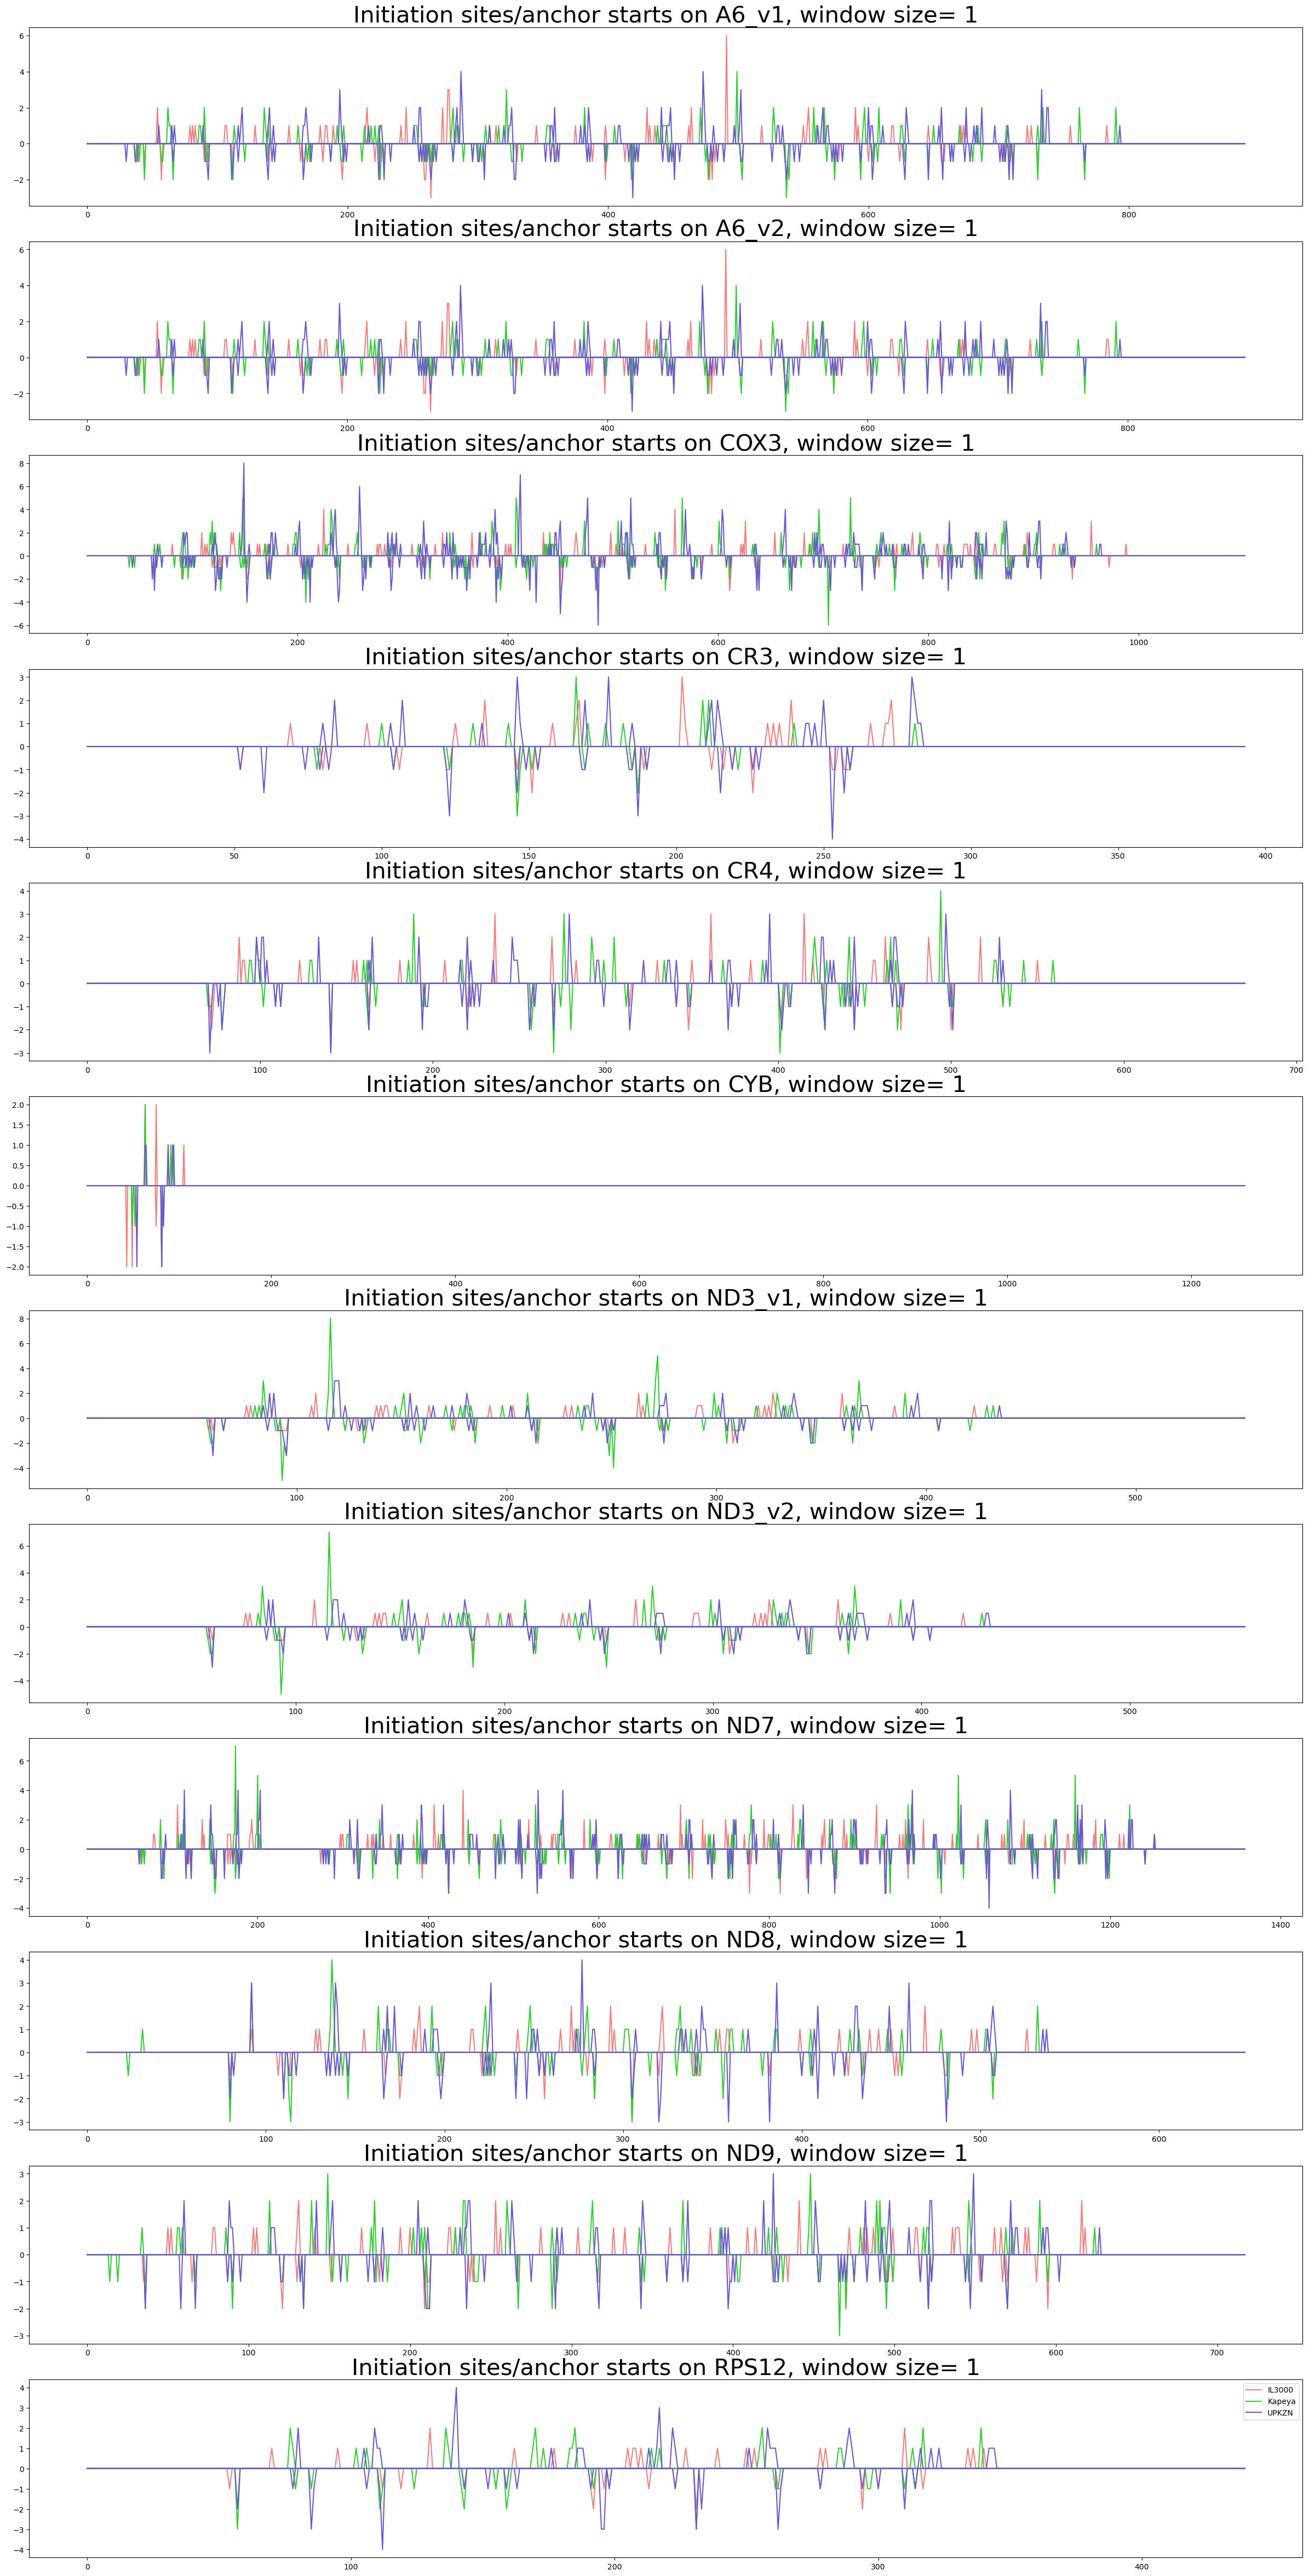

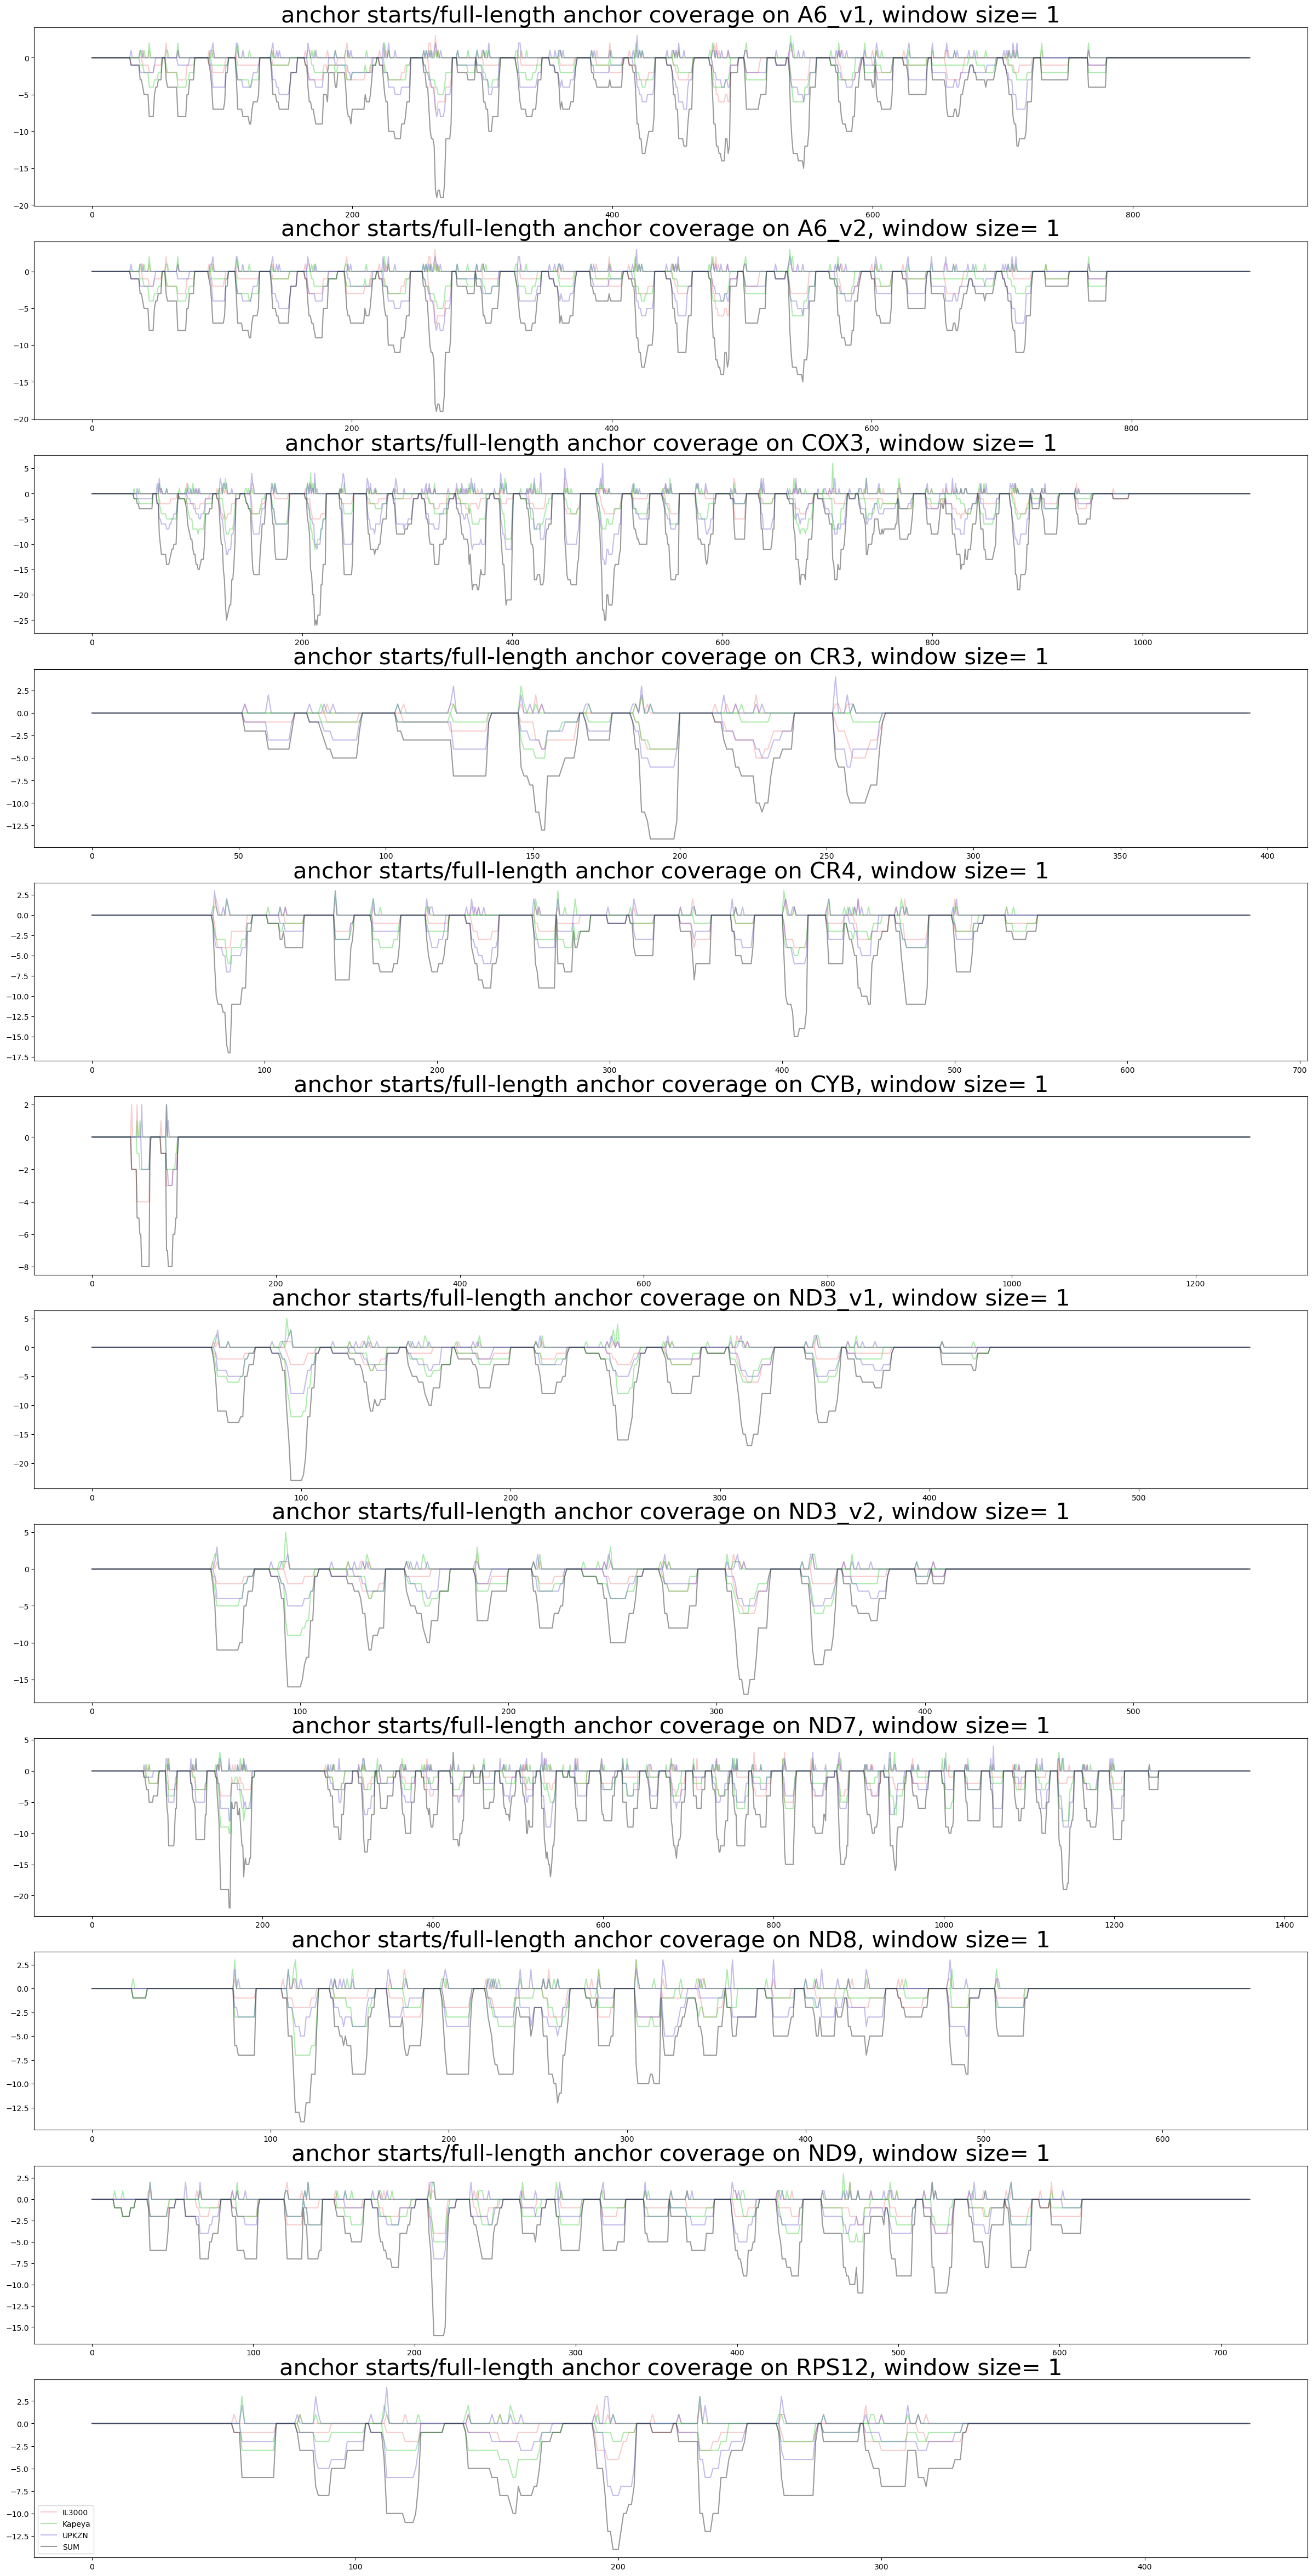

In [8]:
file1=f'{outdir}/compare_anchor_init_{strain}.pdf'
file2=f'{outdir}/overlapping_anchors_{strain}.pdf'
sum_anchor=slide_window_plot_by_strain(strain_grna,small_u,insertions,file1,file2,ws=1,figw=30,figh=60)

In [9]:
#make gRNA_family with anchor
gRNA_families=anchor_clusters(sum_anchor)
#use the coverage plot to direct subdivision of 9 clusters
subdivision(gRNA_families,'A6_v1','A6_v1-164_219',['1146677899999955562222244','222478897777777777566653111'])
subdivision(gRNA_families,'A6_v1','A6_v1-646_696',['33333333334788888778875543332','223333333433333321'])
subdivision(gRNA_families,'A6_v2','A6_v2-646_696',['33333333334788888778875543332','223333333433333321'])
subdivision(gRNA_families,'COX3','COX3-730_782',['2344456999999885555788787777777777766','69999999988864'])
subdivision(gRNA_families,'COX3','COX3-794_843',['366668888888642232','444444888999999999999999966664'])
subdivision(gRNA_families,'CR4','CR4-426_462',['2666666666','233455999999996555332222'])
subdivision(gRNA_families,'ND7','ND7-145_191',['1146899999999999999566655','77689999999999998111'])
subdivision(gRNA_families,'ND8','ND8-221_268',['134578899999999942233333354','222555999999997753'])
subdivision(gRNA_families,'ND8','ND8-305_355',['89999999999999','5777777554433211','2445777777774442'])
subdivision(gRNA_families,'ND8','ND8-400_445',['2222235535555555523332','445555555576555555553'])
subdivision(gRNA_families,'ND9','ND9-453_511',['344444444444488999999899994444222222223','26777999999999933'])
subdivision(gRNA_families,'RPS12','RPS12-294_333',['334555777777777733','6667555555555544411'])
#sort again at the end
gRNA_families={m:{k: v for k, v in sorted(gRNA_families[m].items(), key=lambda item: item[1]['bound'][0])} for m in gRNA_families}
total=sum([len(v) for v in gRNA_families.values()])
print(f"identified {total} anchor clusters")

identified 225 anchor clusters
{'bound': (164, 189), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '1146677899999955562222244'}
{'bound': (192, 219), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '222478897777777777566653111'}
{'bound': (646, 675), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '33333333334788888778875543332'}
{'bound': (678, 696), 'gRNA': [], 'mRNA': 'A6_v1', 'coverage': '223333333433333321'}
{'bound': (646, 675), 'gRNA': [], 'mRNA': 'A6_v2', 'coverage': '33333333334788888778875543332'}
{'bound': (678, 696), 'gRNA': [], 'mRNA': 'A6_v2', 'coverage': '223333333433333321'}
{'bound': (730, 767), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '2344456999999885555788787777777777766'}
{'bound': (768, 782), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '69999999988864'}
{'bound': (794, 812), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '366668888888642232'}
{'bound': (813, 843), 'gRNA': [], 'mRNA': 'COX3', 'coverage': '444444888999999999999999966664'}
{'bound': (426, 436), 'gRNA': [], 'mRNA': 'CR4', 'coverage

In [10]:
#update family info and gRNA info
gRNA_dict,gRNA_families=assign_gRNA_families_anchor(gRNA_dict,gRNA_families)
check_gRNA_number(gRNA_dict,gRNA_families)
#remove records on certain mRNAs
gRNA_families={k:v for k,v in gRNA_families.items() if k in to_plot}
gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
check_gRNA_number(gRNA_dict,gRNA_families)
for g in gRNA_dict:
    gRNA_dict[g]['gRNA']=g
gf_presence={}
for k in gRNA_families:
    for gf in gRNA_families[k]:
        gf_presence[gf]=round(len(set([i.split('_')[0] for i in gRNA_families[k][gf]['gRNA']]))/3,2) 

number of gRNA in gRNA family dict: 2344 
number of gRNA in gRNA dict:2344
number of gRNA in gRNA family dict: 2344 
number of gRNA in gRNA dict:2344


In [11]:
#number of gRNA families per isolate
def isolate_gfam(gfam,gRNA_dict):
    strains=['IL3000','Kapeya','UPKZN']
    strain_gfam={}
    for s in strains:
        strain_gfam[s]=[gf for gf,v in gfam.items() if s in [g.split('_')[0] for g in v['gRNA']]]
        print(s,len(strain_gfam[s]))
    return(strain_gfam)

def isolate_mRNA_gfam(gRNA_family,gRNA_dict,csv_out):
    strains=['IL3000','Kapeya','UPKZN']
    strain_gfam={}
    for k in gRNA_family:
        strain_gfam[k]={}
        for s in strains:
            strain_gfam[k][s]=len([gf for gf,v in gRNA_family[k].items() if s in [g.split('_')[0] for g in v['gRNA']]])
    df=pd.DataFrame.from_dict(strain_gfam,orient='index')
    df.to_csv(csv_out)

strain_gfam=isolate_gfam(gfam,gRNA_dict)
strain_gfam=isolate_mRNA_gfam(gRNA_families,gRNA_dict,f'{outdir}/gRNA_fam_per_mRNA.csv')      

IL3000 220
Kapeya 228
UPKZN 226


In [12]:
filename=f'{outdir}/gRNA_combined_visual_{strain}.pdf'
init_grna_comb(sum_anchor,gRNA_families,gRNA_dict,gf_presence,filename,figw=100,figh=100)

In [13]:
#filename=f'{outdir}/gRNA_by_isolate_{strain}.pdf'
#init_grna_comb(sum_anchor,gRNA_families,gRNA_dict,gf_presence,filename,figw=100,figh=100,color_by_subspecies=True)

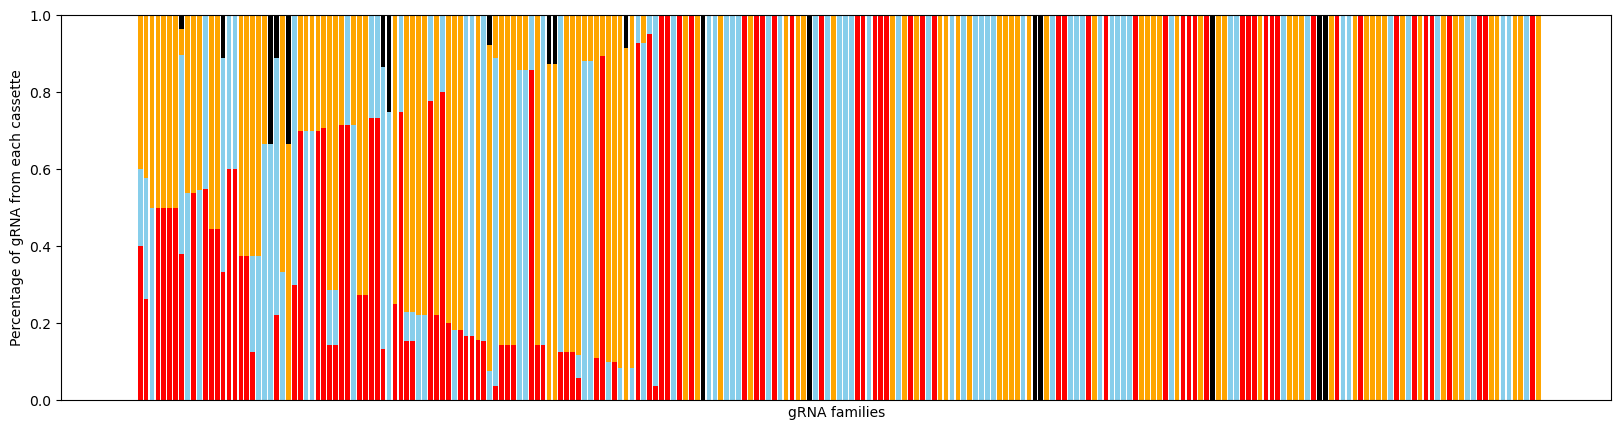

235 gRNA families contained over 50.0% gRNAs from one cassette
222 gRNA families contained over 60.0% gRNAs from one cassette
211 gRNA families contained over 70.0% gRNAs from one cassette
186 gRNA families contained over 80.0% gRNAs from one cassette
158 gRNA families contained over 90.0% gRNAs from one cassette
149 gRNA families contained over 100% gRNAs from one cassette
11 gRNAs were found in 1 isolates
['A6_v1-526_534', 'A6_v2-526_534', 'COX3-721_727', 'COX3-972_987', 'CR4-299_310', 'ND3_v1-294_303', 'ND7-553_559', 'ND8-23_31', 'ND9-14_27', 'ND9-588_594', 'RPS12-213_221']
{'A6_v1-526_534': ['29'], 'A6_v2-526_534': ['29'], 'COX3-721_727': ['27'], 'COX3-972_987': ['49'], 'CR4-299_310': ['29'], 'ND3_v1-294_303': ['27'], 'ND7-553_559': ['27'], 'ND8-23_31': ['28'], 'ND9-14_27': ['24', '27'], 'ND9-588_594': ['28'], 'RPS12-213_221': ['28']}
18 gRNAs were found in 2 isolates
209 gRNAs were found in 3 isolates


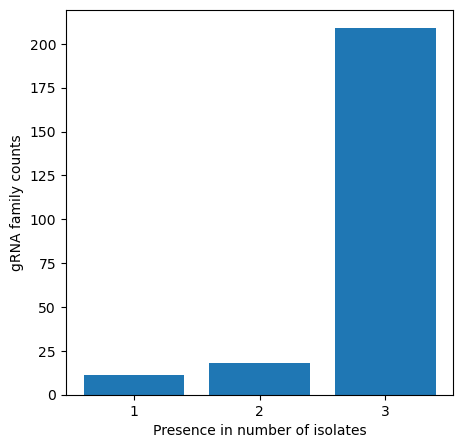

In [14]:
def cassette_distribution(gRNA_families,gRNA_dict,figw=20,figh=5):
    cs,isocounts=['I','II','III','Orphan'],[1,2,3]
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    cass={gf:[gRNA_dict[g]['cassette_label'] for g in v['gRNA']] for gf,v in gfam.items()}
    cass={gf: {c: v.count(c)/len(v) for c in cs} for gf,v in cass.items()}
    #sort and put the gRNAs with the least conserved cassettes first
    cass={k:v for k,v in sorted(cass.items(), key=lambda item: max(item[1].values()))}
    df=pd.DataFrame.from_dict(cass, orient='index')
    fig,ax = plt.subplots(1,1,figsize=(figw,figh))
    ax.bar(df.index, (df['I']), label='I',color='r')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='skyblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='orange')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']),label='Orphan',color='black')
    ax.set_xticks([])
    ax.set_xlabel('gRNA families')
    ax.set_ylabel('Percentage of gRNA from each cassette')
    plt.show()
    #some statistics
    casmax={k:max(v.values()) for k,v in cass.items()}
    #all in one cassette
    for cut in [0.5,0.6,0.7,0.8,0.9, 1]:
        s1=[k for k,v in casmax.items() if v>=cut]
        print(f"{len(s1)} gRNA families contained over {cut*100}% gRNAs from one cassette")
    #isolates
    iso={gf: set([g.split('_')[0] for g in v['gRNA']]) for gf,v in gfam.items()}
    data={k:len(v) for k,v in iso.items()}
    for i in isocounts:
        s=list(data.values()).count(i)
        print(f"{s} gRNAs were found in {i} isolates")
        if i==1:
            a=[k for k,v in data.items() if v==1]
            print(a)
            a={gf: [gRNA_dict[g]['length'] for g in gfam[gf]['gRNA']] for gf in a }
            print(a)
    fig,ax = plt.subplots(1,1,figsize=(5,5))
    x=[1,2,3]
    ax.bar(x,[list(data.values()).count(i) for i in x])
    ax.set_xticks(x)
    ax.set_xlabel('Presence in number of isolates')
    ax.set_ylabel('gRNA family counts')
    plt.show()
    return(df)

cass=cassette_distribution(gRNA_families,gRNA_dict)

In [15]:
#load minicircles and cassette info
il3000='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_minicircles.fasta'
kpy='/home/jovyan/Tcongo_PacBio/Infiles/Kepeya_minicircles.fasta'
upk='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_minicircles.fasta'
matchil='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_cleaned_minicircles.log'
matchkpy='/home/jovyan/Tcongo_PacBio/Infiles/Kapeya_cleaned_minicircles.log'
matchupk='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_cleaned_minicircles.log'
cassil='/home/jovyan/Tcongo_PacBio/Infiles/IL3000_cassettes.txt'
casskpy='/home/jovyan/Tcongo_PacBio/Infiles/Kapeya_cassettes.txt'
cassupk='/home/jovyan/Tcongo_PacBio/Infiles/UPKZN_cassettes.txt'
#load minicircles
def load_mini(fasta,matches,strain):
    mini_dict=SeqIO.to_dict(SeqIO.parse(fasta,'fasta'))
    match_dict={list(filter(None,l.strip('\n').split(' ')))[1]:list(filter(None,l.strip('\n').split(' ')))[0] for l in open(matches)}
    mini_dict={f"{strain}_{match_dict[k]}":v for k,v in mini_dict.items()}
    return(mini_dict)
def get_cassette_info (txt,strain,strain_seq):
    with open(txt) as handle:
        keys=[x for x in next(handle).strip('\n').split(' ') if x !='']
        cassette_dict={f'cassette_{index}': {i:j for i,j in zip(keys,[x for x in line.strip('\n').split(' ') if x !=''][1:])}
                       for index,line in enumerate(handle)}
        cassette_dict={f"{strain}_{v['mO_name']}_{v['cassette_label']}":{k:int(value) 
                                                                if 'start' in k or 'end' in k else value for k,value in v.items()} 
                       for k,v in cassette_dict.items()}
        for k,v in cassette_dict.items():
            cassette_dict[k]['seq']=strain_seq[f"{strain}_{cassette_dict[k]['mO_name']}"].seq[v['forward_start']:v['reverse_end']]
    return(cassette_dict)
il3000seq=load_mini(il3000,matchil,'IL3000')
kapeyaseq=load_mini(kpy,matchkpy,'Kapeya')
upkznseq=load_mini(upk,matchupk,'UPKZN')
cassil=get_cassette_info (cassil,'IL3000',il3000seq)
casskpy=get_cassette_info (casskpy,'Kapeya',kapeyaseq)
cassupk=get_cassette_info (cassupk,'UPKZN',upkznseq)
cassdict={'IL3000':cassil,'Kapeya':casskpy,'UPKZN':cassupk}

In [16]:
#editing block analysis
def editing_block(gRNA_families,gRNA_dict,anchorlen=6,figw=20,figh=5):
    cs,isocounts,isolates=['I','II','III','Orphan'],[1,2,3],['IL3000','Kapeya','UPKZN']
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    ed_blocks={gf:{s:(min([gRNA_dict[g]['mRNA_start'] for g in v['gRNA'] if s in g]),max([gRNA_dict[g]['mRNA_end']-anchorlen for g in v['gRNA'] if s in g])) 
                   for s in isolates if s in [i.split('_')[0] for i in v['gRNA']]} 
               for gf,v in gfam.items()}
    startsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[0] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    endsdiff={gf: max([abs(pair[0]-pair[1]) for pair in combinations([pos[1] for pos in d.values()],2)]) for gf,d in ed_blocks.items() if len(d)>1 }
    data=[list(startsdiff.values()),list(endsdiff.values())]
    labels=['start difference','end difference']
    #basic stats
    for label,d in zip(labels,data):
        print(label)
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        print(f"mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6), sharey=False)
    ax = sns.violinplot(data, inner=None,cut=0,orient='h')
    ax=sns.stripplot(data, edgecolor='black', linewidth=1, palette=['white']*len(data) ,orient='h') 
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'Differences (nt)')
    #
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=labels,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(labels,style='italic')
    ax.set_xlabel(f'Differences (nt)')
    plt.show()
    return(ed_blocks)
def plot_editng_blocks(ed_blocks_by_mrna,filename,exception,figw=100,figh=50,floor=-20,shared_only=False):
    taxon_dict={'IL3000':'lightcoral','Kapeya':'limegreen','UPKZN':'slateblue'}
    shape_dict={'IL3000':'o','Kapeya':'v','UPKZN':'s'} #circle,triangle,square
    add_dict={'IL3000':0,'Kapeya':-2,'UPKZN':-4} #circle,triangle,square
    c,c_dict=0,{'I':'r','II':'skyblue','III':'orange','Orphan':'black'}
    insertions=read_editing_sites(small_u) #1 for insertions
    dels=read_deletion_sites(deletion) #0 for deletion sites
    fig,axs = plt.subplots(len(ed_blocks_by_mrna),1,figsize=(figw,figh))
    for k,v in ed_blocks_by_mrna.items():
        ax,d=axs[c],0
        ax.set_title(f'Editing blocks on {k} (nt)',fontdict={'fontsize': 40, 'fontweight': 40})
        c+=1
        #plot init sites
        #ax.plot(range(len(counts[k])),counts[k],label=k)
        ax.set_xlim(left=0,right=len(insertions[k])+60)
        #plot boundaries
        #draw insertion sites: 0 for insertions
        x=[i for i,c in enumerate(insertions[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='purple',linewidth=5)
        d+=-1
        #draw deletions
        x=[i for i,c in enumerate(dels[k]) if c==0 ] 
        y=[d]*len(x)
        ax.scatter(x,y,marker=3,color='red',linewidth=5)
        d+=-1
        #draw gRNA families
        ceiling=d
        if shared_only==False:
            tmp=ed_blocks_by_mrna[k]
        else: #include only gf in all three isolates
            tmp={gf:v for gf,v in ed_blocks_by_mrna[k].items() if len(v)==3 or gf in exception}
        for i,gf in enumerate(tmp):
            if i%2==1:
                d=-4 #alternate starting height
            else:
                d=-10
            ax.text(max([i[1] for i in ed_blocks_by_mrna[k][gf].values()]),d,f"{gf}")
            for s,bound in ed_blocks_by_mrna[k][gf].items():
                ax.add_patch(Rectangle((bound[0], d+add_dict[s]), bound[1]-bound[0], -1,
                              facecolor = taxon_dict[s],alpha=0.6)) #coding region
    plt.savefig(filename)
    plt.show()

def length_of_ed_block_stats(ed_blocks_by_mrna):
    data=[[b[1]-b[0] for gf in v for b in v[gf].values()] for k,v in ed_blocks_by_mrna.items()]
    summary={}
    #basic stats
    for label,d in zip(ed_blocks_by_mrna.keys(),data):
        mean=round(sum(d)/len(d),2)
        med=statistics.median(d)
        mod=statistics.mode(d)
        summary[label]={'mean':mean,'median':med,'mode':mod,'max':max(d),'min':min(d)}
        #print(f"{label} mean: {mean}, median: {med}, mode: {mod}, max: {max(d)}, min: {min(d)}")
    df=pd.DataFrame.from_dict(summary,orient='index')
    print(df)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    ax.boxplot(data,labels=ed_blocks_by_mrna.keys(),vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.tick_params(labelsize=20)
    ax.set_yticklabels(ed_blocks_by_mrna.keys(),style='italic')
    ax.set_xlabel(f'Length of effective editing range of gRNA families (nt)')
    plt.show()
    return(df)
#
def calculate_interval(ed_blocks_by_mrna,exception,shared_only=False):
    isolates=['IL3000','Kapeya','UPKZN']
    summary={k:{} for k in ed_blocks_by_mrna}
    for k in ed_blocks_by_mrna:
        if shared_only==False:
            tmp=ed_blocks_by_mrna[k]
        else: #include only gf in all three isolates
            tmp={gf:v for gf,v in ed_blocks_by_mrna[k].items() if len(v)==3 or gf in exception}
        for s in isolates:
            starts=[v[s][0] for gf,v in tmp.items() if s in v]
            ends=[v[s][1] for gf,v in tmp.items() if s in v]
            d1=[starts[i+1]-n for i,n in enumerate(starts[:-1])]
            d2=[ends[i+1]-n for i,n in enumerate(ends[:-1])]
            mean=round(sum(d1)/len(d1),2)
            med=statistics.median(d1)
            mod=statistics.mode(d1)
            if len(d1)>2:
                sd=round(statistics.stdev(d1),2)
            else:
                sd=np.nan
            #sts={'mean':mean,'median':med,'mode':mod,'max':max(d1),'min':min(d1)}
            sts=(mean,sd)
            summary[k][s]=sts#
    df=pd.DataFrame.from_dict(summary,orient='index')
    return(df)
            


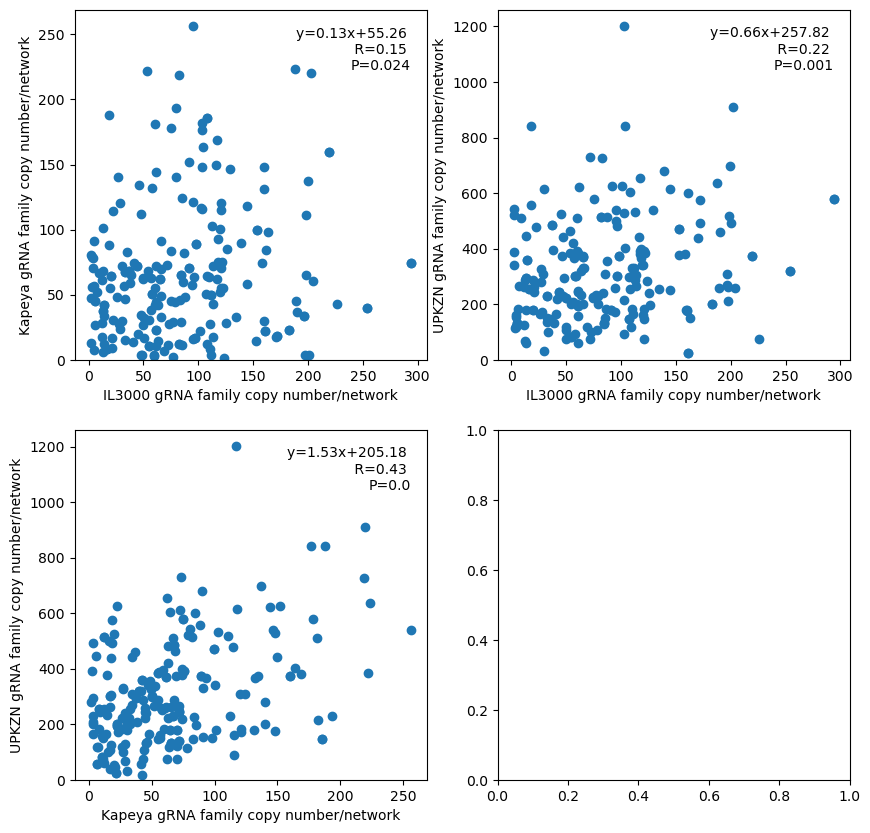

In [17]:
def gRNA_fam_relative_abundance_correlation(gRNA_families,gRNA_dict):
    cs,isocounts,isolates=['I','II','III','Orphan'],[1,2,3],['IL3000','Kapeya','UPKZN']
    gfam={gf:v for k in gRNA_families for gf,v in gRNA_families[k].items()}
    for gf,v in gfam.items():
        gfam[gf]['copy']={s:sum([gRNA_dict[g]['copy']for g in v['gRNA'] if s in g]) for s in isolates}
    #plot correlation
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,pair in enumerate(combinations(isolates, 2)):
        if i<2:
            ax=axs[0,i%2]
        else:
            ax=axs[1,i%2]
        x=[v['copy'][pair[0]] for gf,v in gfam.items() if not v['copy'][pair[0]] ==0 and v['copy'][pair[1]]!=0]
        y=[v['copy'][pair[1]] for gf,v in gfam.items() if not v['copy'][pair[1]] ==0 and v['copy'][pair[0]]!=0]
        #x=[v['copy'][pair[0]] for gf,v in gfam.items()]
        #y=[v['copy'][pair[1]] for gf,v in gfam.items()]
        #corr = round(np.corrcoef(x,y)[0,1],2)
        corr=linregress(x, y)
        ax.scatter(x,y)
        ax.set_ylim(bottom=0)
        ax.set_xlabel(f"{pair[0]} gRNA family copy number/network")
        ax.set_ylabel(f"{pair[1]} gRNA family copy number/network")
        ax.text(max(x),max(y),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,3)}",ha='right',va='top')
    plt.show()
    return(gfam)

gfam=gRNA_fam_relative_abundance_correlation(gRNA_families,gRNA_dict)

start difference
mean: 2.07, median: 1, mode: 0, max: 18, min: 0
end difference
mean: 2.26, median: 1, mode: 0, max: 14, min: 0


/tmp/ipykernel_306/2372913116.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels,style='italic')


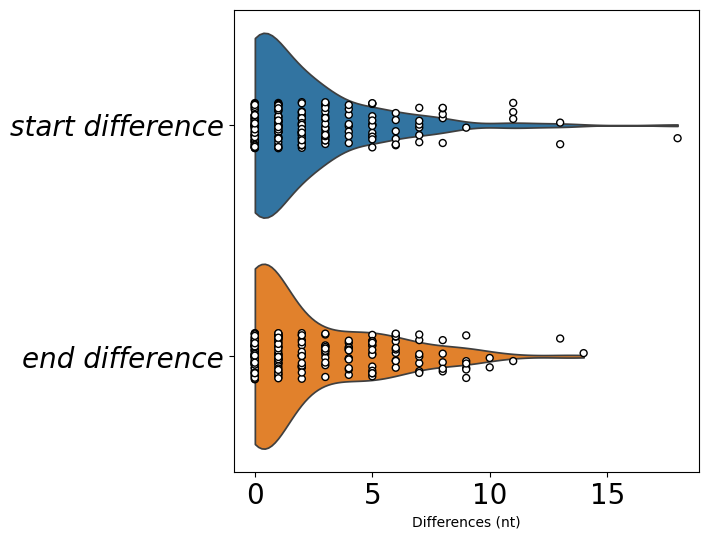

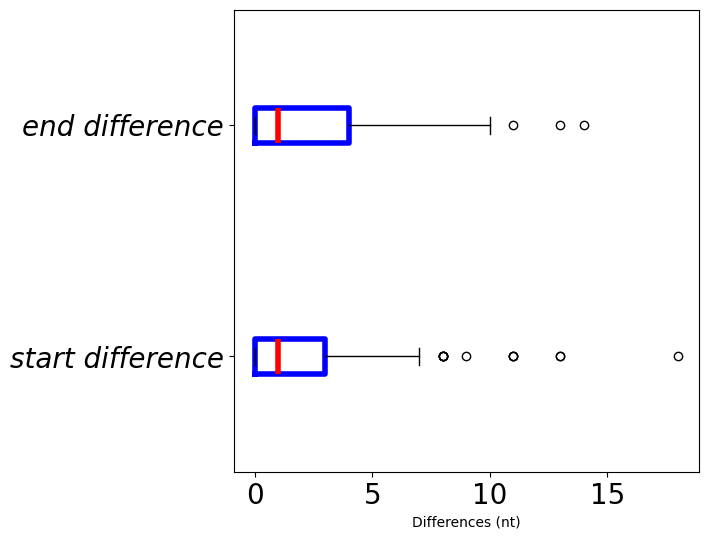

In [18]:
ed_blocks=editing_block(gRNA_families,gRNA_dict,anchorlen=6,figw=20,figh=5)
ed_blocks_by_mrna={k:{gf:v for gf,v in ed_blocks.items() if k in gf} for k in gRNA_families}
exception=['A6_v1-678_696','A6_v1-730_751','A6_v2-678_696','A6_v2-730_751','A6_v2-734_752','COX3-972_987','CR4-217_236','ND8-356_373','ND8-452_469']

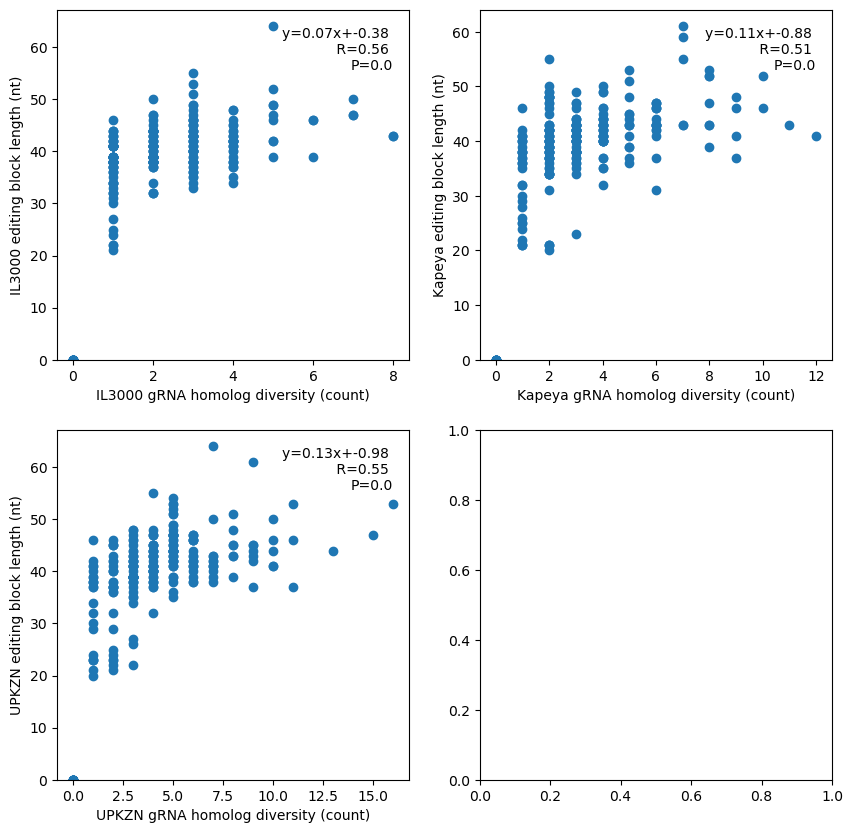

In [19]:
def length_correlation_ed_blocks(gfam,ed_blocks):
    isolates=['IL3000','Kapeya','UPKZN']
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10), sharey=False)
    for i,s in enumerate(isolates):
        ax=axs[round(i/2),i%2]
        x=[ed_blocks[gf].get(s,(0,0))[1]-ed_blocks[gf].get(s,(0,0))[0] for gf, v in gfam.items()]
        y=[len([g for g in gfam[gf]['gRNA'] if s in g]) for gf, v in gfam.items()]
        corr=linregress(x, y)
        ax.scatter(y,x)
        ax.set_ylim(bottom=0)
        ax.set_ylabel(f"{s} editing block length (nt)")
        ax.set_xlabel(f"{s} gRNA homolog diversity (count)")
        ax.text(max(y),max(x),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \nP={round(corr.pvalue,5)}",ha='right',va='top')
    plt.show()
            

length_correlation_ed_blocks(gfam,ed_blocks)

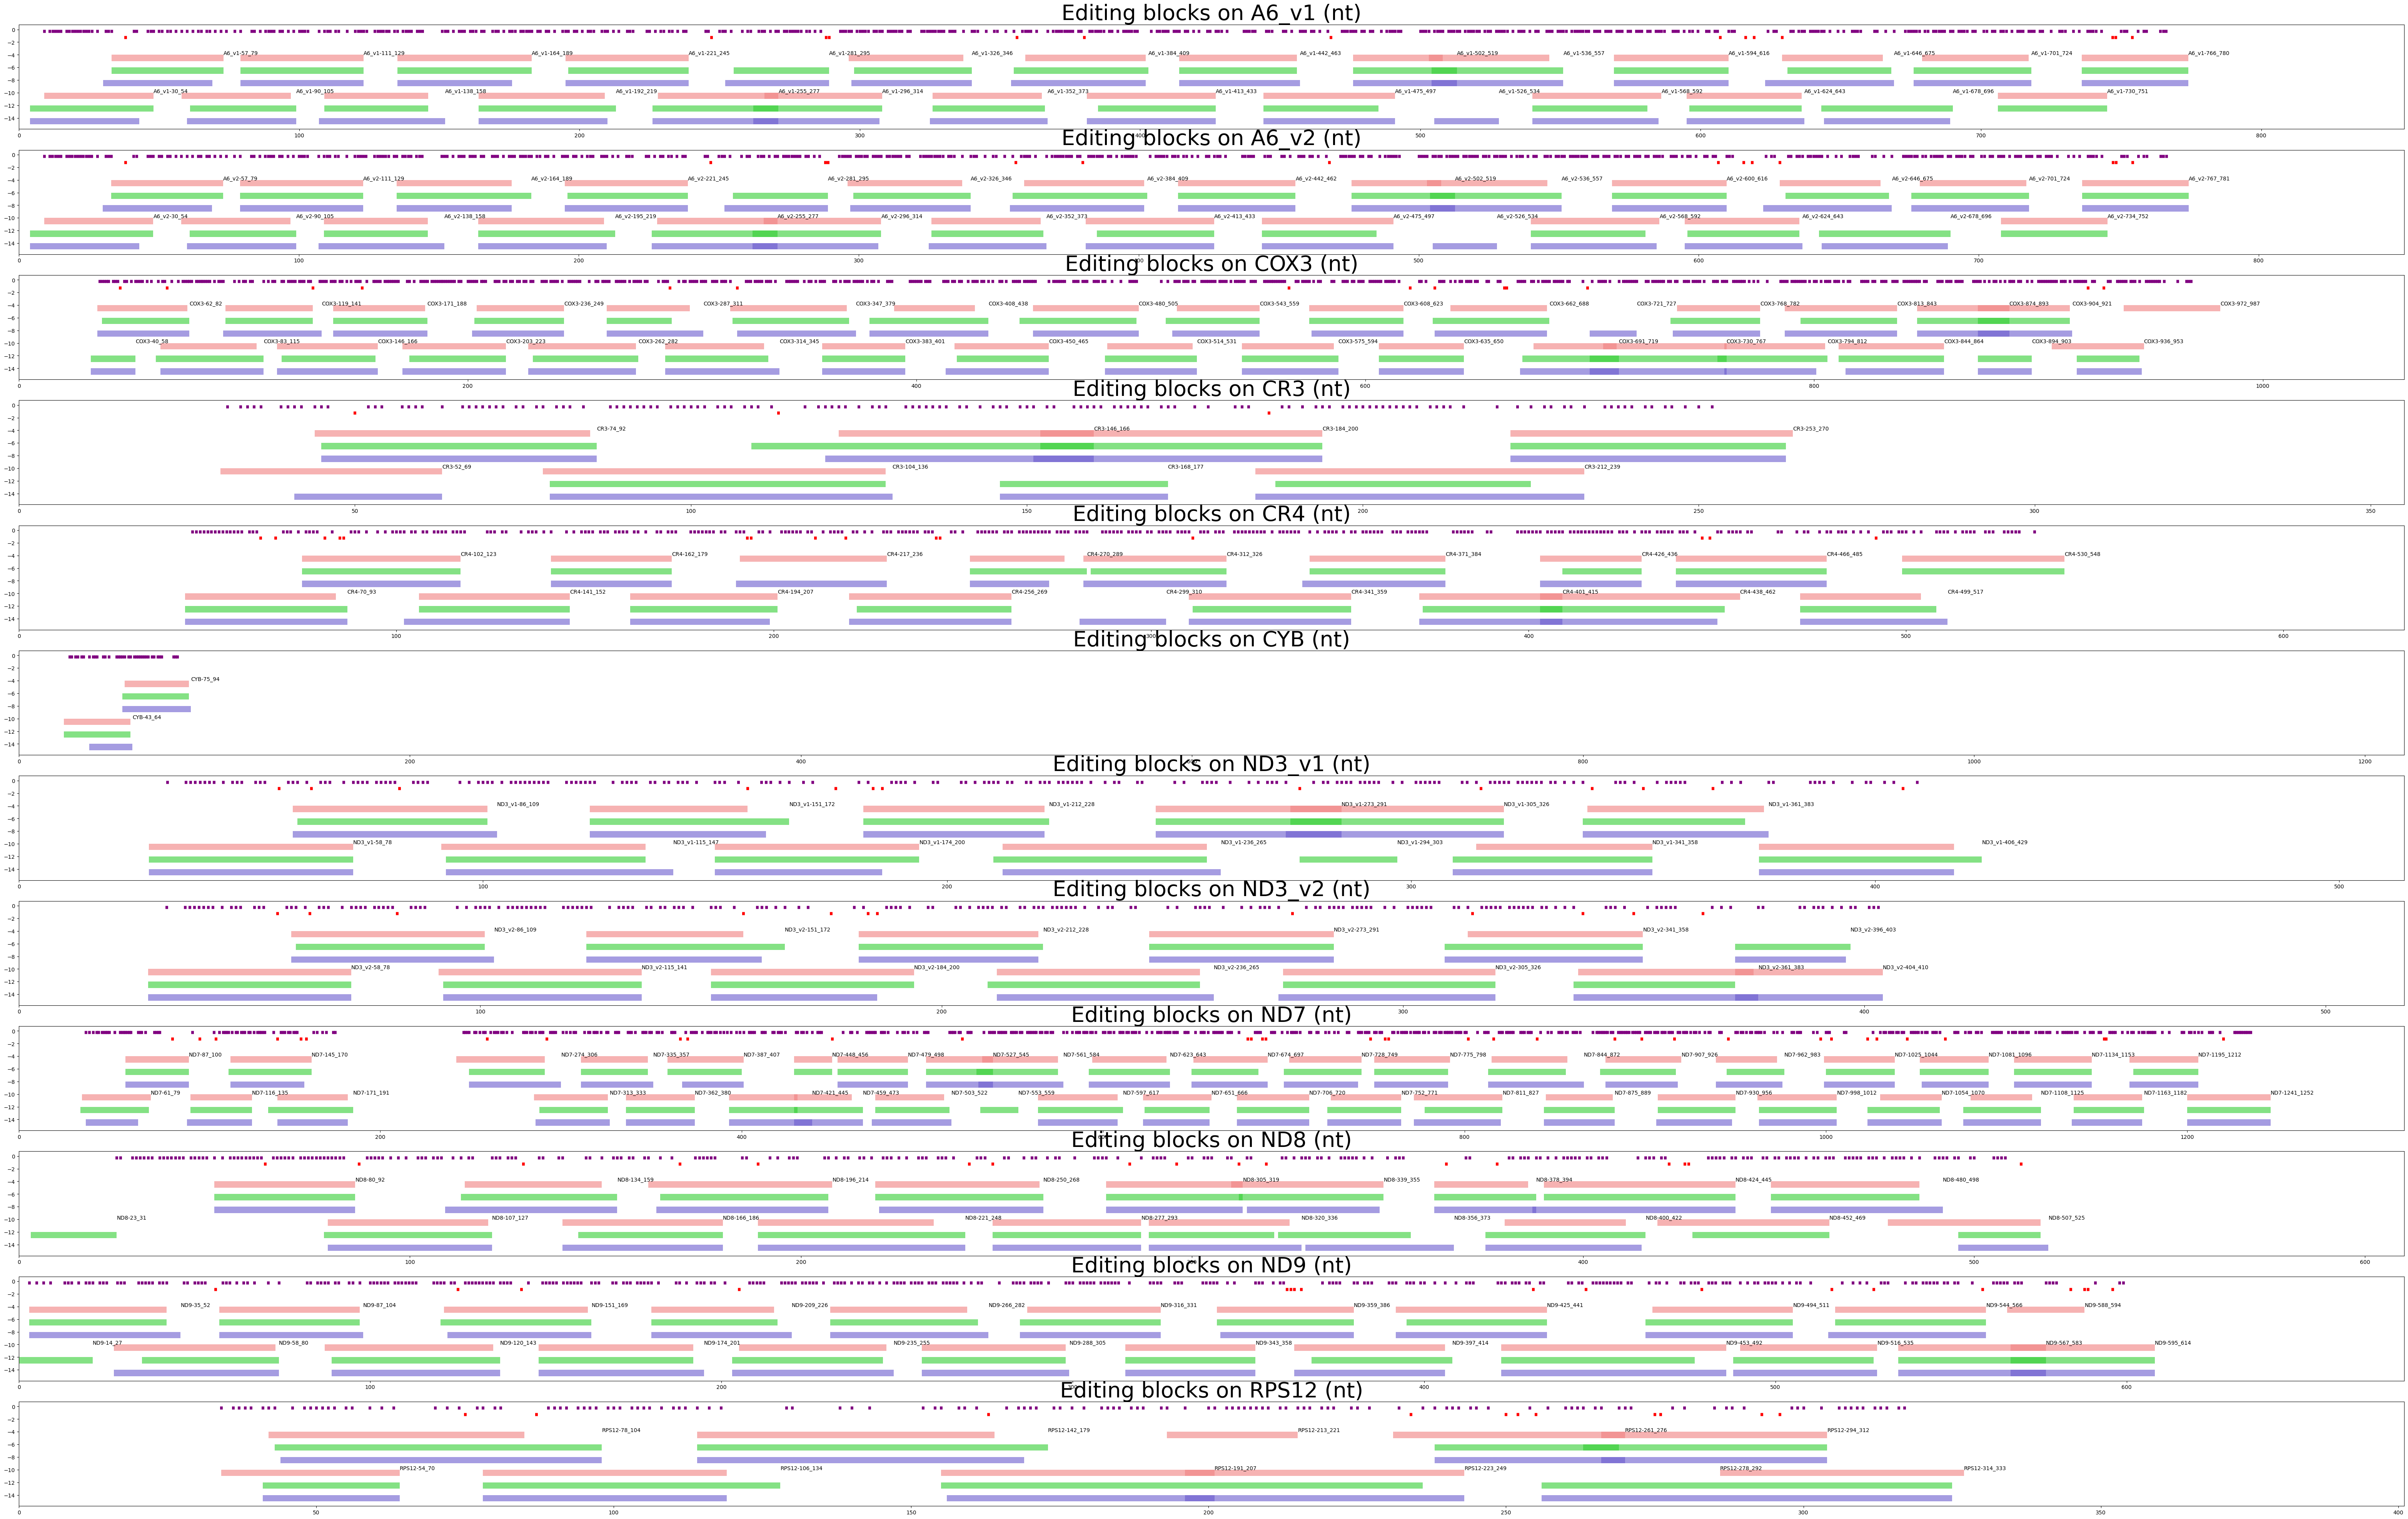

In [20]:
outfile=f"{outdir}/Effective_editing_range.pdf"
plot_editng_blocks(ed_blocks_by_mrna,outfile,exception,figw=80,figh=50,floor=-20,shared_only=False)

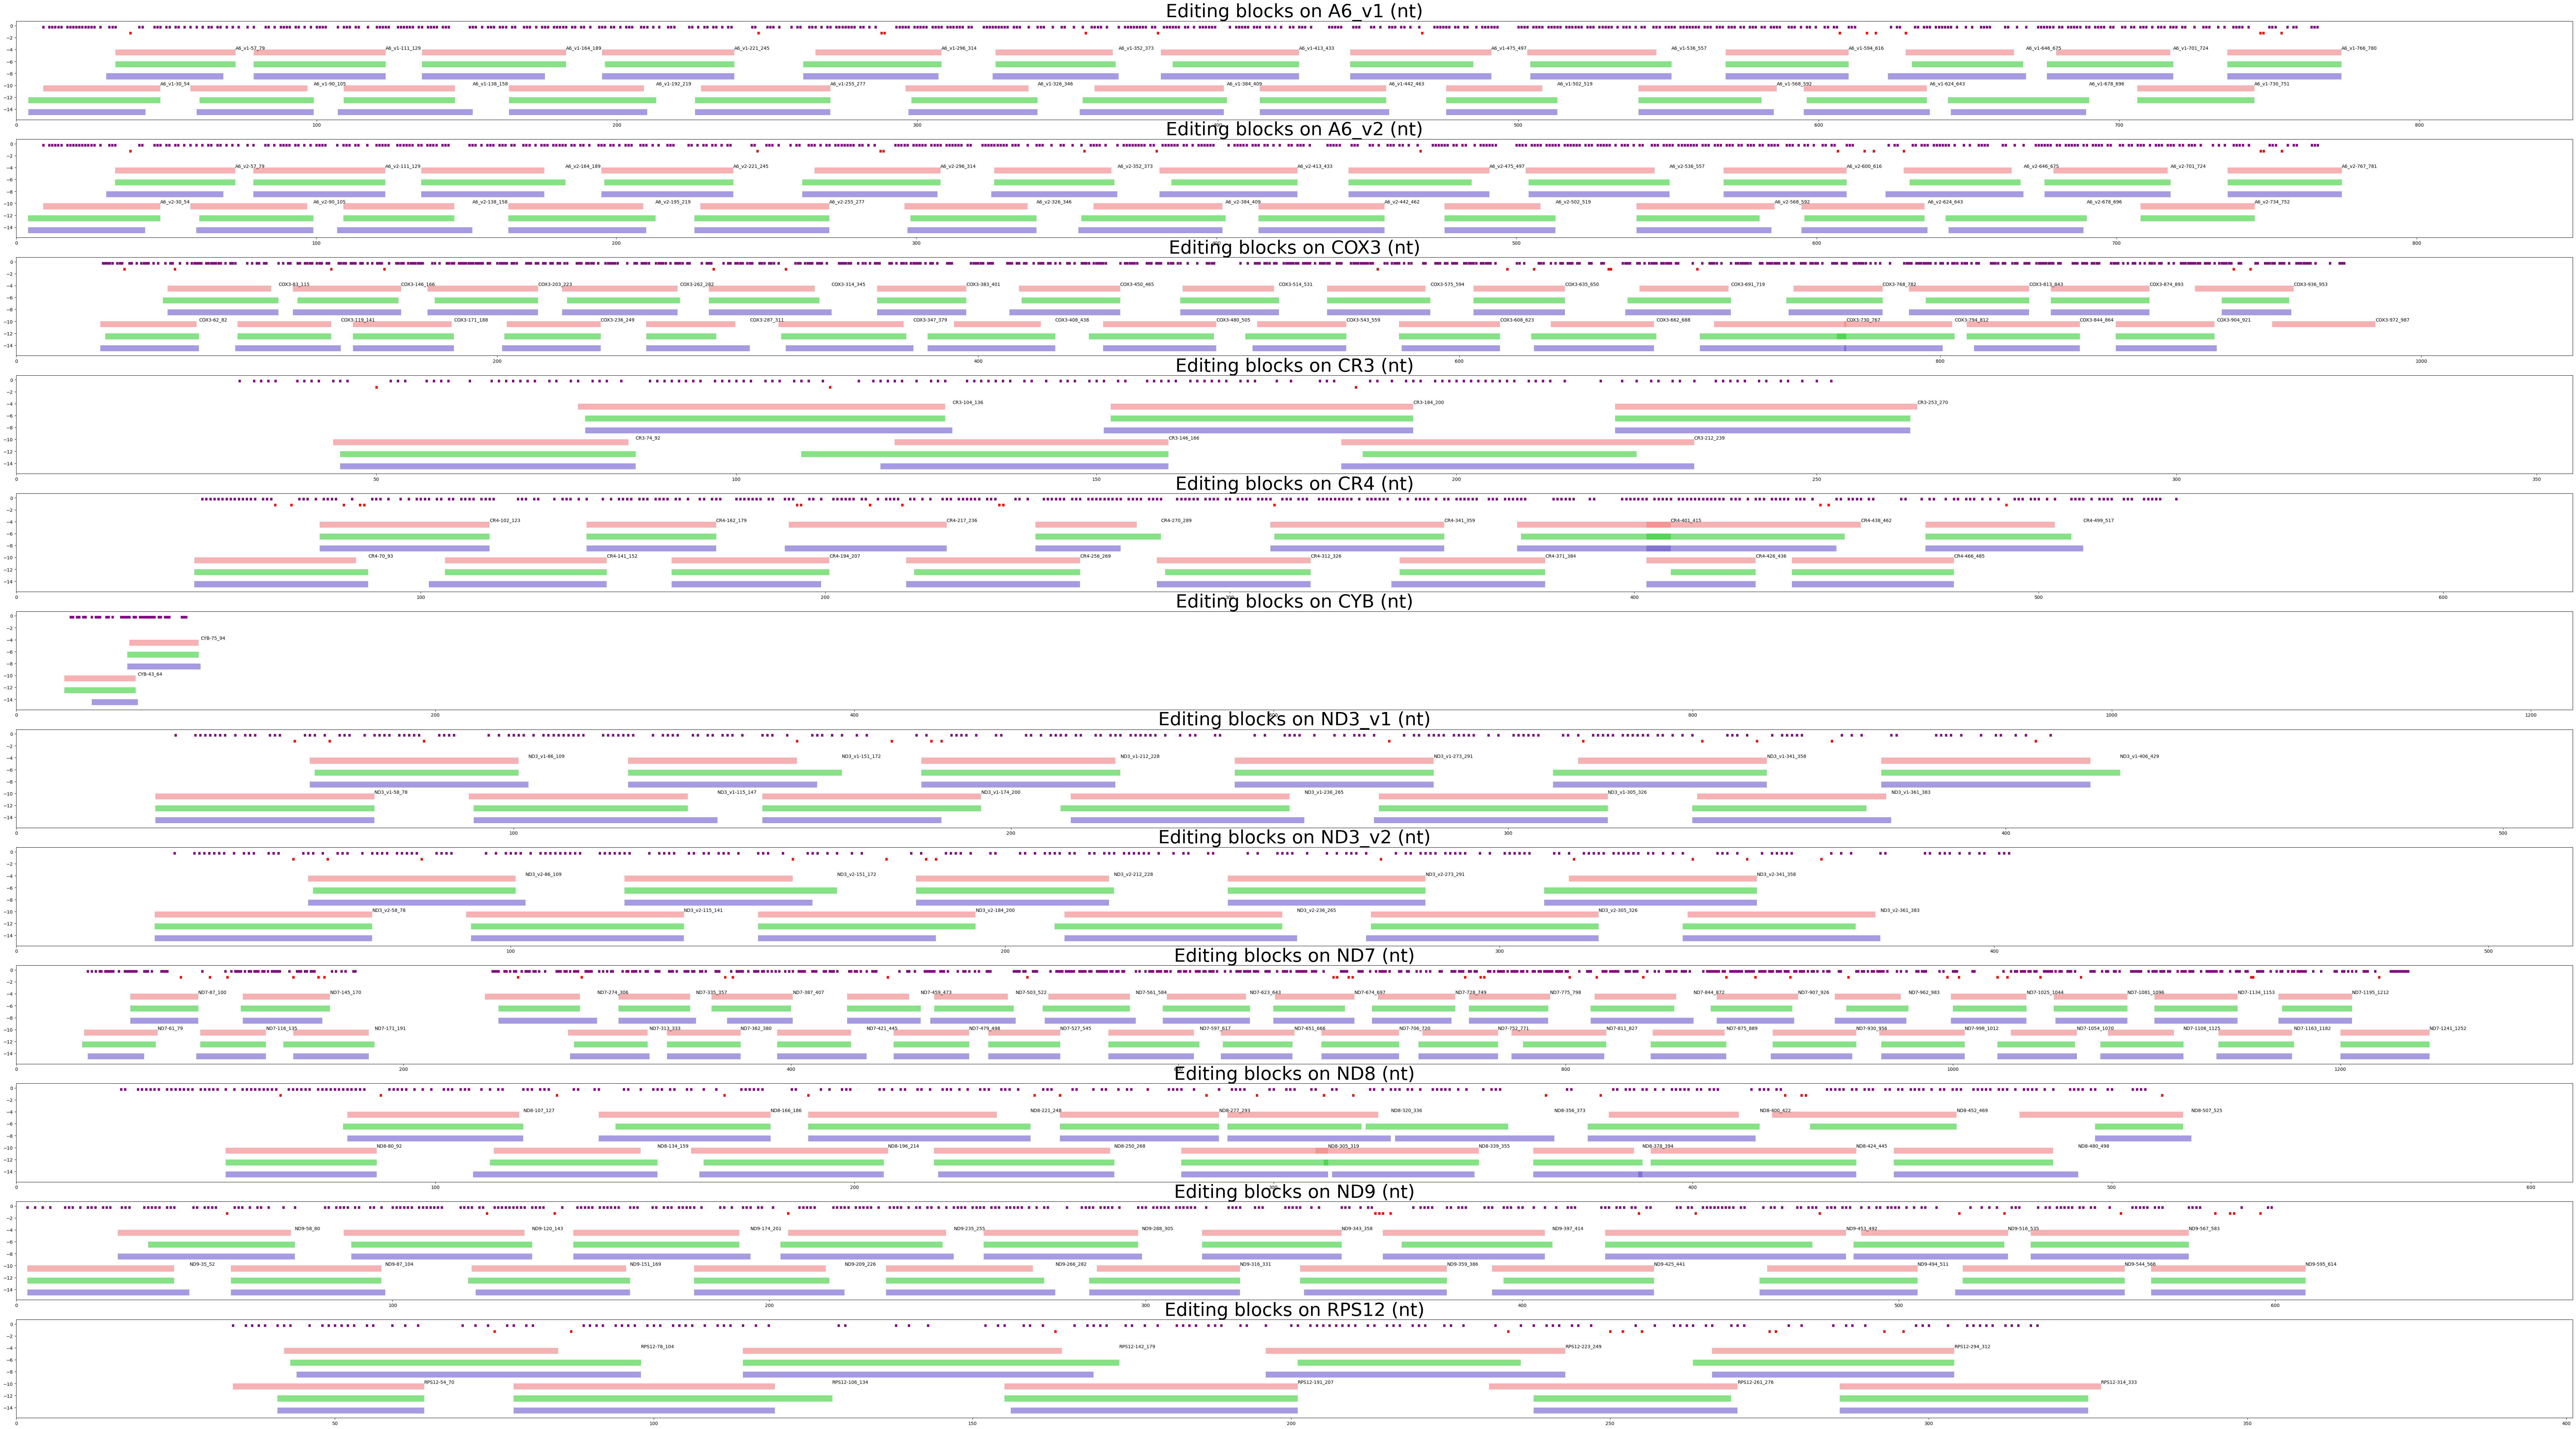

In [21]:
outfile=f"{outdir}/Effective_editing_range_shared_only.pdf"
plot_editng_blocks(ed_blocks_by_mrna,outfile,exception,figw=100,figh=55,floor=-20,shared_only=True)

         mean  median  mode  max  min
A6_v1   41.82    42.0    42   49   23
A6_v2   41.70    42.0    42   49   23
COX3    42.17    42.0    41   61   20
CR3     40.73    41.0    41   51   22
CR4     37.86    39.0    43   53   21
CYB     32.00    34.0    34   35   22
ND3_v1  41.57    43.0    44   49   21
ND3_v2  40.32    42.0    44   47   24
ND7     39.83    40.0    38   53   21
ND8     38.38    38.0    38   53   21
ND9     41.80    41.0    43   64   21
RPS12   40.33    41.0    41   59   22


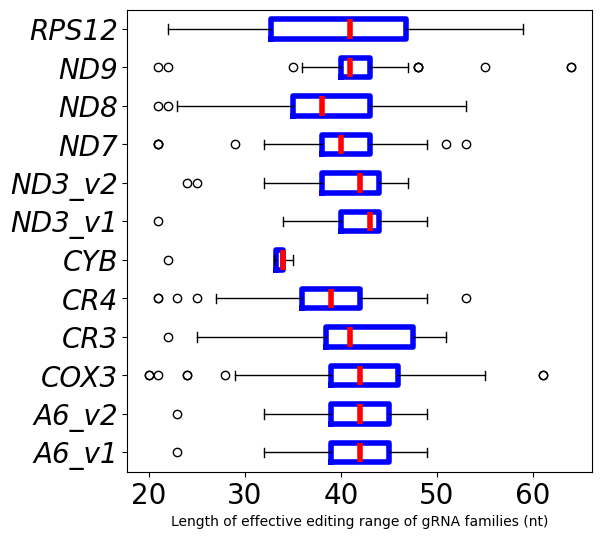

In [22]:
df=length_of_ed_block_stats(ed_blocks_by_mrna)
csv_out=f"{outdir}/editing_block_length_per_mRNA.csv"
df.to_csv(csv_out)

In [23]:
#no graph, just csv output to make a table
df=calculate_interval(ed_blocks_by_mrna,exception,shared_only=True)
csv_out=f"{outdir}/editing_block_interval_per_isolate_per_mRNA.csv"
df.to_csv(csv_out)
print(df)

                IL3000          Kapeya           UPKZN
A6_v1    (30.29, 5.96)   (29.28, 5.19)    (30.5, 7.45)
A6_v2    (30.33, 5.93)   (29.32, 5.22)   (30.54, 7.62)
COX3       (30.1, 4.5)   (30.34, 6.61)   (30.41, 5.34)
CR3       (35.6, 5.55)    (35.4, 4.72)    (35.4, 4.04)
CR4      (28.53, 8.62)  (30.57, 13.61)   (28.53, 8.87)
CYB        (31.0, nan)     (30.0, nan)     (17.0, nan)
ND3_v1   (31.55, 4.37)   (31.55, 3.45)   (31.55, 3.39)
ND3_v2    (31.0, 4.19)    (30.9, 2.85)    (30.9, 2.77)
ND7     (30.66, 12.65)  (30.68, 14.39)  (30.61, 13.46)
ND8      (26.75, 9.74)  (26.24, 10.63)  (27.88, 12.91)
ND9       (28.2, 5.09)    (28.2, 4.74)    (28.2, 4.74)
RPS12    (31.5, 11.53)  (30.62, 13.85)  (30.62, 13.47)


In [24]:
#number of gRNAs in gRNA family
def gRNA_per_gfam(gfam):
    data=[len(v['gRNA']) for k,v in gfam.items()]
    x=list(set(data))
    data={i:data.count(i) for i in x}
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    ax.bar(x,data.values())
    ax.set_xticks(x)
    ax.set_xlabel('number of gRNAs in the fmaily')
    ax.set_ylabel('gRNA family counts')
    plt.show()
    print(data)

def filter_gfam(gfam,gRNA_dict,cassdict,out_dir,cutoff=20,outgroups=['ND9-453_492']):
    tmp={k:v for k,v in gfam.items() if len(v['gRNA'])>=cutoff}
    outgrna=[SeqRecord(Seq(gRNA_dict[g]['gRNA_seq']),id=f"{outgroup}_{g}_{gRNA_dict[g]['cassette_label']}",name='',description=f"{gRNA_dict[g]['mO_name']}")
                 for outgroup in outgroups for g in gfam[outgroup]['gRNA']]
    outcass=[SeqRecord(cassdict[g.split('_')[0]][f"{gRNA_dict[g]['mO_name']}_{gRNA_dict[g]['cassette_label']}"]['seq'],
                             id=f"{outgroup}_{gRNA_dict[g]['mO_name']}_{gRNA_dict[g]['cassette_label']}",
                             name='',description=f"{g}")
               for outgroup in outgroups for g in gfam[outgroup]['gRNA'] 
             if gRNA_dict[g]['cassette_label'] in ['I','II','III']]
    for gf,v in tmp.items():
        records=[SeqRecord(Seq(gRNA_dict[g]['gRNA_seq']),id=f"{gf}_{g}_{gRNA_dict[g]['cassette_label']}",name='',description=f"{gRNA_dict[g]['mO_name']}")
                 for g in v['gRNA']]
        cassettes=[SeqRecord(cassdict[g.split('_')[0]][f"{gRNA_dict[g]['mO_name']}_{gRNA_dict[g]['cassette_label']}"]['seq'],
                             id=f"{gf}_{gRNA_dict[g]['mO_name']}_{gRNA_dict[g]['cassette_label']}",
                             name='',description=f"{g}")
                 for g in v['gRNA'] if gRNA_dict[g]['cassette_label'] in ['I','II','III']]
        SeqIO.write(records+outgrna,f"{out_dir}/gRNA_family_fasta/{gf}_{len(records)}.fasta",'fasta')
        SeqIO.write(cassettes+outcass,f"{out_dir}/gRNA_family_cassettes/{gf}_{len(records)}_cass.fasta",'fasta')
        cs=len(set([gRNA_dict[g]['cassette_label'] for g in v['gRNA']]))
        print(gf,len(records),cs)
    print(len(tmp))

#gRNA_per_gfam(gfam)
filter_gfam(gfam,gRNA_dict,cassdict,outdir,cutoff=20,outgroups=[])

A6_v1-255_277 22 1
A6_v2-255_277 22 1
COX3-119_141 27 2
COX3-203_223 27 3
COX3-347_379 29 4
COX3-383_401 22 1
COX3-408_438 22 2
COX3-480_505 28 2
COX3-662_688 21 2
COX3-813_843 21 1
ND3_v1-86_109 24 2
ND7-171_191 21 2
ND7-930_956 21 2
ND7-1134_1153 20 2
14


In [25]:
#get minicircle class
mini_dict,mini_df=assign_gRNA_fam_to_mini(gRNA_dict,gRNA_families)
mini_families=make_minicircle_family(mini_dict,gRNA_dict)

422


308
[  0 137 119  36  14   1   0   1]
308
[ 0 66 71 63 52 21 17  4  4  0  3  2  1  1  1  1  0  0  1]
[  0   2 101 195  10]


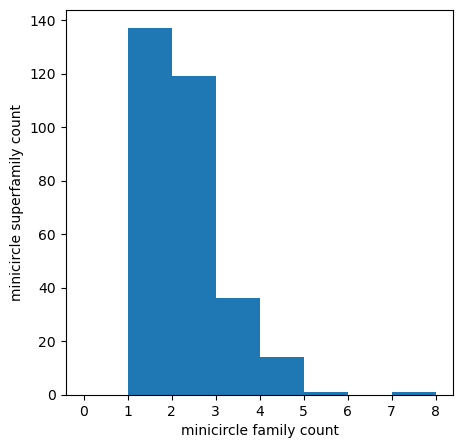

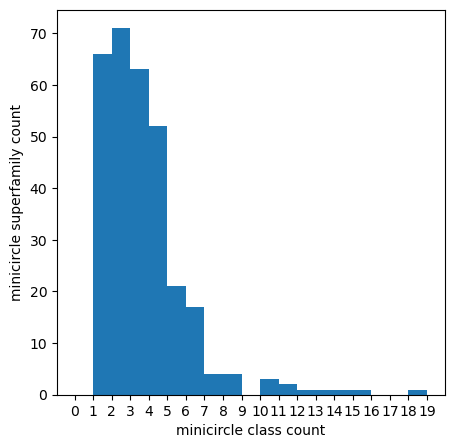

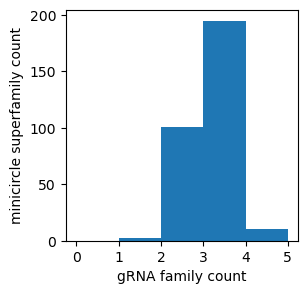

In [88]:
def make_superfamilies_by_famiy(mini_families): #should give the same result by clustering class, need to do that 
    superf={}
    for mf,mfrecord in mini_families.items():
        #put gRNA family to cassettes
        hit=0
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mfrecord['cassettes'].values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mf)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_families[mf]['cassettes'],'population':[mf]}
    return(superf)
def make_superfamilies_by_class(mini_dict,gRNA_dict): #should give the same result by clustering class, need to do that 
    superf={}
    for mini in mini_dict:
        #put gRNA family to cassettes
        hit=0
        mini_casettes={c: set([i for g in v for i in gRNA_dict[g]['gRNA_family']])
                       for c,v in mini_dict[mini].items() if c in ['I','II','III','Orphan']}
        if superf=={}:
            count=1
            superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
        else:
            for smf,smfrecord in superf.items():
                test=[0 if set(j).issubset(set(i)) else 1 
                      for i,j in zip(smfrecord['cassettes'].values(),mini_casettes.values())]
                if sum(test)==0:
                    superf[smf]['population'].append(mini)
                    hit+=1
            if hit==0: #if no matches were found
                count+=1
                superf[f"smf{count}"]={'cassettes': mini_casettes,'population':[mini]}
    return(superf)
#merge superfamilies (tie up loose ends)
def merge_superfamilies(superfam,intype):
    remove=[]
    for smf1,v1 in superfam.items():
        for smf2,v2 in superfam.items():
            if smf1 != smf2:
                test=[0 if c2.issubset(c1) else 1 for c1,c2 in zip(v1['cassettes'].values(),v2['cassettes'].values()) ]
                if sum(test)==0:
                    superfam[smf1]['population']=superfam[smf1]['population']+superfam[smf2]['population']
                    remove.append(smf2)
    superf={k:v for k,v in superfam.items() if k not in remove}
    print(len(superf))
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=False)
    #number of minicircle families
    data=[len(v['population']) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'minicircle {intype} count')
    return(superf)
def gRNA_fam_per_superfamily(superf):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3, 3), sharey=False)
    #number of minicircle families
    data=[sum([1 for k,c in v['cassettes'].items() if c!=set()]) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily count')
    ax.set_xlabel(f'gRNA family count')

superfam1=make_superfamilies_by_famiy(mini_families)
superfam2=make_superfamilies_by_class(mini_dict,gRNA_dict)
superfam1=merge_superfamilies(superfam1,'family')
superfam2=merge_superfamilies(superfam2,'class')
gRNA_fam_per_superfamily(superfam1)

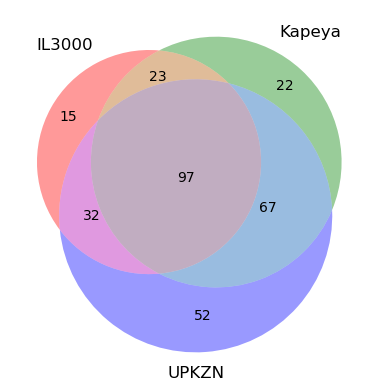

In [85]:
def number_of_minicircle_families(superfam):
    sets={}
    for sp in ['IL3000','Kapeya','UPKZN']:
        superf=[k for k,v in superfam.items() if sp in [m.split('_')[0] for m in v['population']]]
        #print(superf)
        sets[sp]=set(superf)
    venn3([v for v in sets.values()], sets.keys())
    return(sets)

sets=number_of_minicircle_families(superfam2) #comeback

In [27]:
#add minicircle family/cassette info to gfam dict
for gf in gfam:
    gfam[gf]['minicircle_family']={mf:k for mf,v in mini_families.items() for k,c in v['cassettes'].items() if gf in c }
    gfam[gf]['minicircles']={gRNA_dict[g]['mO_name']:gRNA_dict[g]['cassette_label'] for g in gfam[gf]['gRNA']}
    gfam[gf]['superfamily']={smf:k for smf,v in superfam1.items() for k,c in v['cassettes'].items() if gf in c}

[ 1 21 30 42 49 30 23 12 10 11  3  1  3  1  1]
number of gf present in a single cassette only: 122


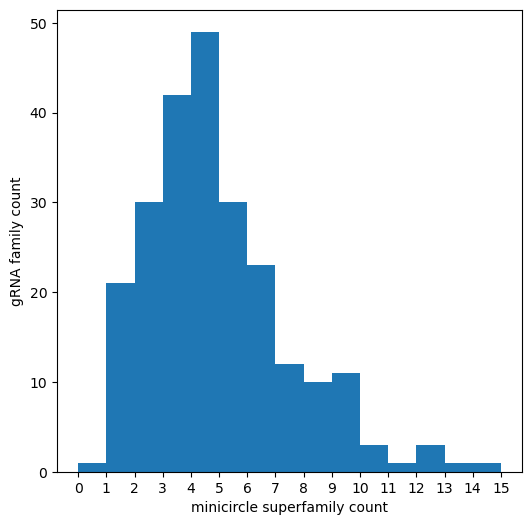

In [28]:
def gfam_in_superfam_stats(gfam):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    data=[len(gf['superfamily']) for gf in gfam.values()]
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('gRNA family count')
    ax.set_xlabel('minicircle superfamily count')
    #number of gf present in the same cassette among superfamilies
    samec=[gf for gf,v in gfam.items() if len(set([c for c in v['superfamily'].values() ]))==1 and 'v2' not in gf]
    print('number of gf present in a single cassette only:',len(samec))
    
gfam_in_superfam_stats(gfam)

In [95]:
#recombination detection
multi_cass={gf:set([v for v in v['minicircle_family'].values() if v !='Orphan']) for gf,v in gfam.items() if len(set([v for v in v['minicircle_family'].values() if v !='Orphan']))>1 and  'v2' not in gf}
single_cass={gf:set([v for v in v['minicircle_family'].values()]) for gf,v in gfam.items() if len(set([v for v in v['minicircle_family'].values()]))==1 and  'v2' not in gf}
count_mRNA=[gf.split('-')[0] for gf in multi_cass]
count_mRNA={m:count_mRNA.count(m) for m in set(count_mRNA)}
#print(count_mRNA)
count_cn={g:len(v) for g,v in multi_cass.items()}
#print({i:list(count_cn.values()).count(i) for i in [2,3]})
count_cn2={pair:len([v for v in multi_cass.values() if list(v) ==list(pair)]) for pair in combinations(['I','II','III'],2)}
#count the nunber of cassettes
count_cass=[f"{g}_{c}" for gf in multi_cass for g,c in gfam[gf]['minicircles'].items() if c!='Orphan']
print('number of cassettes',len(set(count_cass)))
#extract cassettes
def sequence_identity_cassettes(multi_cass,gfam,cassdict):
    records,samec,diffc={},[],[]
    for gf in multi_cass:
        cass=[f"{m}_{c}" for m,c in gfam[gf]['minicircles'].items() if c!='Orphan']
        records[gf]=[]
        #calculate sequence identity by pair-wise alignments
        for pair in combinations(cass,2):
            c1=cassdict[pair[0].split('_')[0]][pair[0]]['seq']
            c2=cassdict[pair[1].split('_')[0]][pair[1]]['seq']
            aligner = Align.PairwiseAligner()
            c1,c2 = aligner.align(c1,c2)[0]
            seqid=round(sum([1 for i,j in zip(c1,c2) if i==j])/len(c1)*100,2)
            records[gf].append((pair[0],pair[1],seqid))
            if pair[0].split('_')[-1]==pair[1].split('_')[-1]:
                samec.append(seqid)
            else:
                diffc.append(seqid)
    return(records,samec,diffc)
def return_cassette_seq_id(c1,c2):
    aligner = Align.PairwiseAligner()
    c1,c2 = aligner.align(c1,c2)[0]
    seqid=round(sum([1 for i,j in zip(c1,c2) if i==j])/len(c1)*100,2)
    print(seqid)
def visualize_seqid_cass(records,samec,diffc,samec_control,baseline):
    a=ttest_ind(samec, diffc)
    b=ttest_ind(samec_control, diffc)
    c=ttest_ind(samec_control, samec)
    print(sum(samec)/len(samec),sum(diffc)/len(diffc),sum(samec_control)/len(samec_control),a.pvalue,b.pvalue,c.pvalue)
    a=ttest_ind(samec, baseline)
    b=ttest_ind(diffc, baseline)
    c=ttest_ind(samec_control, baseline)
    print(round(sum(baseline)/len(baseline),2),a.pvalue,b.pvalue,c.pvalue)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data=[samec,diffc,samec_control,baseline]
    ax.boxplot(data,labels=['multi cassettes-same','multi cassettes_different','single cassette','baseline'],vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.set_xlabel('Sequence Percent Identity')
    #ax.set_ylabel('number of cassettes')
    #ax.set_xticks(range(0,20,4))
#compare sequence identity of cassettes at the same positions
#from the same isolate vs different isolates
def output_gfam_minicircle(mini_dict,gRNA_dict,mini):
    out={c:[gRNA_dict[i]['gRNA_family'][0] for i in v] for c,v in mini_dict[mini].items() if c in ['I','II','III','Orphan']}
    print(out)
def visualize_seqid_cass_same_diffsmf(diffsmf, samesmf,baseline):
    #same
    diff=[i[2] for gf,v in diffsmf.items() for i in v]
    same=[i[2] for gf,v in samesmf.items() for i in v]
    a=ttest_ind(same, diff)
    print(sum(same)/len(same),sum(diff)/len(diff),a.pvalue)
    a=ttest_ind(same, baseline)
    print('t test baseline vs same',a.pvalue)
    a=ttest_ind(baseline, diff)
    print('t test baseline vs diff',a.pvalue)
    print(sum(same)/len(same),sum(diff)/len(diff),a.pvalue)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data=[same,diff,baseline]
    ax.boxplot(data,labels=['same superfamilies','different superfamilies','baseline'],vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.set_xlabel('Sequence Percent Identity')
    return(same,diff)
def visualize_seqid_cass_same_diffisolate(records_control,baseline):
    #same isolate
    same=[record[2] for gf in records_control for record in records_control[gf] if record[0].split('_')[0]==record[1].split('_')[0]]
    #different isolate
    diff=[record[2] for gf in records_control for record in records_control[gf] if record[0].split('_')[0]!=record[1].split('_')[0]]
    a=ttest_ind(same, diff)
    print(sum(same)/len(same),sum(diff)/len(diff),a.pvalue)
    a=ttest_ind(same, baseline)
    print('t test baseline vs same',a.pvalue)
    a=ttest_ind(baseline, diff)
    print('t test baseline vs diff',a.pvalue)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data=[same,diff,baseline]
    ax.boxplot(data,labels=['same isolate','different isolate','baseline'],vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.set_xlabel('Sequence Percent Identity')
    return(same,diff)
    #ax.set_ylabel('number of cassettes')
    #ax.set_xticks(range(0,20,4))

#not encoding gRNAs from the same mRNA
def base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict,strain='IL3000',bslsize=500):
    records,count=[],0
    cassettes=['I','II','III']
    canonical=[k for k,v in cassdict[strain].items() if v['type']=='canonical' ]
    for pair in combinations(canonical,2):
        if count<=bslsize:
            k1,k2=pair[0],pair[1]
            m1,m2=cassdict[strain][k1]['mO_name'],cassdict[strain][k2]['mO_name']
            c1,c2=cassdict[strain][k1]['cassette_label'],cassdict[strain][k2]['cassette_label']
            g1,g2=mini_dict[f'{strain}_{m1}'][c1],mini_dict[f'{strain}_{m2}'][c2]
            gf1,gf2={gf.split('-')[0] for g in g1 for gf in gRNA_dict[g]['gRNA_family']},{gf.split('-')[0] for g in g2 for gf in gRNA_dict[g]['gRNA_family']}
            if len(gf1.intersection(gf2))==0:
                count+=1
                s1=cassdict[strain][k1]['seq']
                s2=cassdict[strain][k2]['seq']
                aligner = Align.PairwiseAligner()
                s1,s2 = aligner.align(s1,s2)[0]
                seqid=round(sum([1 for i,j in zip(s1,s2) if i==j])/len(s1)*100,2)
                records.append({'cassette1':k1,'cassette2':k2,'id':seqid} )
    return(records)
def get_box_plot_data(labels, bp):
    rows_list = []
    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)
    return (pd.DataFrame(rows_list))

def get_bsl_levels(bsl):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(3,3), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['baseline']
    bp=ax.boxplot([bsl],labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    levels=get_box_plot_data(labels, bp)
    return(levels)

number of cassettes 821


label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          57.47           61.31   62.57           64.07   

   upper_whisker  
0           68.1

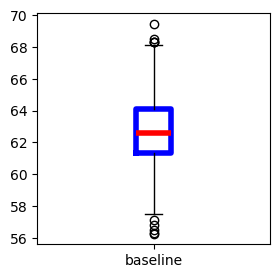

In [97]:
#this is for control, cassettes encoding different gRNA families from IL3000
baseline=base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict,strain='IL3000',bslsize=500)
get_bsl_levels([v['id'] for v in baseline])

label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          54.95           59.54   61.27           62.94   

   upper_whisker  
0          67.07

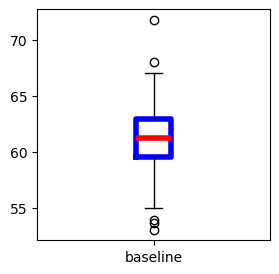

In [98]:
baseline=base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict,strain='Kapeya',bslsize=500)
get_bsl_levels([v['id'] for v in baseline])

label  lower_whisker  lower_quartile  median  upper_quartile  \
0  baseline          57.47           61.63   62.94            64.5   

   upper_whisker  
0          68.75

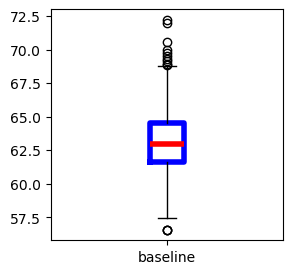

In [99]:
baseline=base_line_seq_id_cass_diff_gf(mini_dict,gRNA_dict,cassdict,strain='UPKZN',bslsize=500)
get_bsl_levels([v['id'] for v in baseline])

In [32]:
output_gfam_minicircle(mini_dict,gRNA_dict,'IL3000_mO_033')
output_gfam_minicircle(mini_dict,gRNA_dict,'IL3000_mO_168')

{'I': ['ND7-1134_1153'], 'II': ['RPS12-314_333'], 'III': ['ND9-316_331'], 'Orphan': []}
{'I': ['ND3_v1-273_291', 'ND3_v2-273_291'], 'II': ['A6_v1-701_724', 'A6_v2-701_724'], 'III': ['ND7-116_135'], 'Orphan': []}


In [33]:
#add superfamily info to minicircle dictionary
for mini in mini_dict:
    mini_dict[mini]['superfamily']=[]
    mini_dict[mini]['family']=[]
    for smf,v in superfam2.items():
        if mini in v['population']:
            mini_dict[mini]['superfamily'].append(smf)
    for mf,v in mini_families.items():
        if mini in v['population']:
            mini_dict[mini]['family'].append(mf)

In [34]:
records,samec,diffc=sequence_identity_cassettes(multi_cass,gfam,cassdict)

In [118]:
len(gfam)

238

In [35]:
records_control,samec_control,temp=sequence_identity_cassettes(single_cass,gfam,cassdict)

In [36]:
longer=set([triple[0] for k,v in records.items() for triple in v if triple[2]>80 and triple[0].split('_')[-1]==triple[1].split('_')[-1]]+
    [triple[1] for k,v in records.items() for triple in v if triple[2]>80 and triple[0].split('_')[-1]==triple[1].split('_')[-1]])
len(longer)#/821
[i for i in diffc if i >80]
{gf:[r for r in records[gf] if r[0].split('_')[-1]!=r[1].split('_')[-1] and r[2]==76.1] for gf in records}
output_gfam_minicircle(mini_dict,gRNA_dict,'UPKZN_mO_062')

{'I': ['ND8-221_248'], 'II': ['COX3-314_345'], 'III': ['ND7-362_380'], 'Orphan': []}


70.3074132730015 63.911890995260826 69.99258862629254 8.123434623362547e-201 3.218128269220063e-194 0.09046761194900366
62.59 0.0 3.481479332396096e-102 0.0


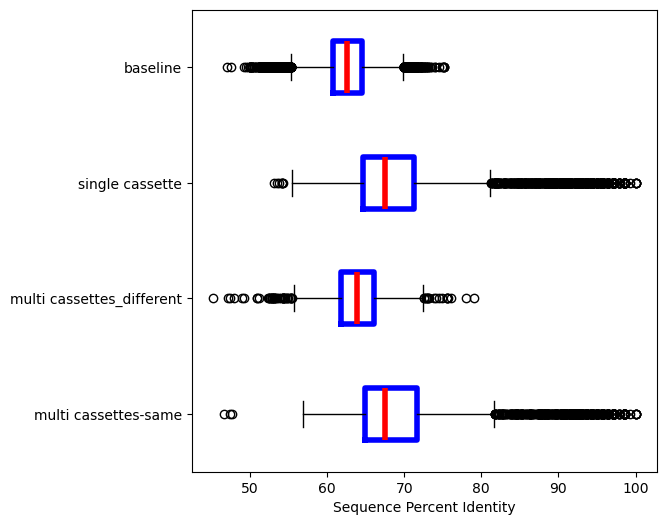

In [37]:
visualize_seqid_cass(records,samec,diffc,samec_control,[d['id'] for d in baseline[:]])

In [38]:
5416-4066
#reorganize the records
record_same_cass=[{'cassette':record[0].split('_')[-1],
                   'c1':record[0].replace('_III','').replace('_II','').replace('_I',''),
                   'c2':record[1].replace('_III','').replace('_II','').replace('_I',''),
                   'id':record[2],
  'smf1':mini_dict[record[0].replace('_III','').replace('_II','').replace('_I','')]['superfamily'],
  'smf2':mini_dict[record[1].replace('_III','').replace('_II','').replace('_I','')]['superfamily']} 
                  for gf,v in records_control.items() for record in v]

79.30106321839098 66.77255964214714 0.0
t test baseline vs same 0.0
t test baseline vs diff 0.0
79.30106321839098 66.77255964214714 0.0
66.90677891654474 66.7035816403311 0.1398781775691543
t test baseline vs same 0.0
t test baseline vs diff 0.0
1366
70 261 19.11
75 40 2.93
80 12 0.88
85 4 0.29
90 3 0.22
95 0 0.0
2658
70 474 17.83
75 69 2.6
80 20 0.75
85 11 0.41
90 5 0.19
95 1 0.04


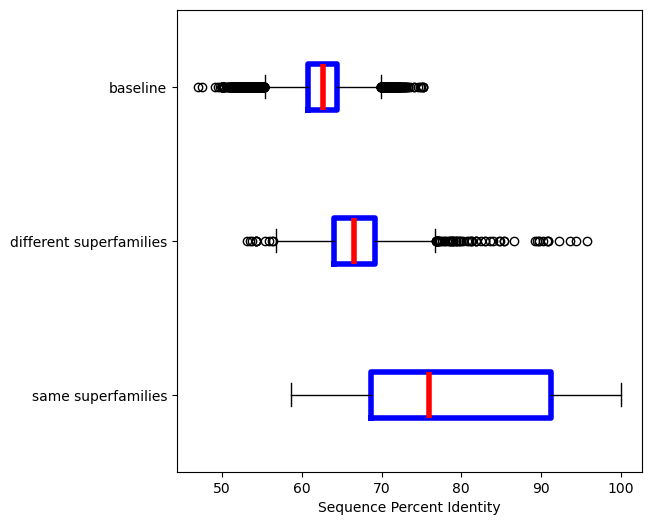

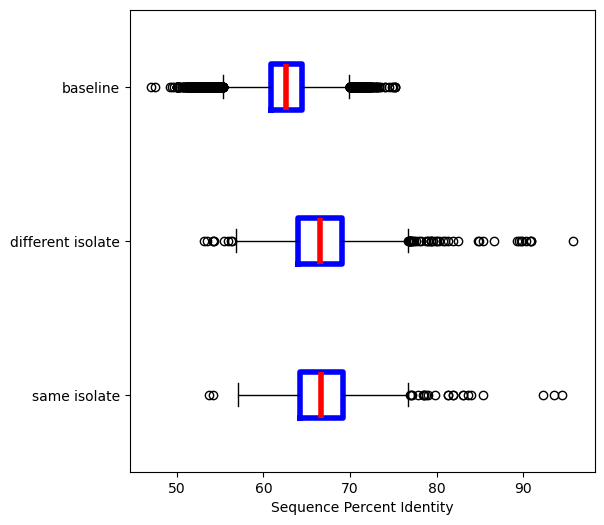

In [39]:
#seperate records from the same vs different superfamilies
diffsmf={gf:[ r for r in v if len(set(mini_dict[r[0].replace('_III','').replace('_II','').replace('_I','')]['superfamily']).intersection(set(mini_dict[r[1].replace('_III','').replace('_II','').replace('_I','')]['superfamily'])))==0] 
         for gf,v in records_control.items()}
samesmf={gf:[ r for r in v if len(set(mini_dict[r[0].replace('_III','').replace('_II','').replace('_I','')]['superfamily']).intersection(set(mini_dict[r[1].replace('_III','').replace('_II','').replace('_I','')]['superfamily'])))!=0] 
         for gf,v in records_control.items()}
visualize_seqid_cass_same_diffsmf(diffsmf, samesmf,[d['id'] for d in baseline[:]])
s,d=visualize_seqid_cass_same_diffisolate(diffsmf,[d['id'] for d in baseline[:]])
#some quick stats
def levels(s):
    print(len(s))
    for cut in [70,75,80,85,90,95]:
        a=[i for i in s if i>=cut]
        print(cut,len(a),round(len(a)/len(s)*100,2))
levels(s)
levels(d)
#visualize_seqid_cass_same_diffisolate(samesmf)

In [40]:
#1.8.Cassette conservation of functionally related minicircles: test within minicircle families
def same_cassette_minifam(mini_families,cassdict):
    records,records_dict=[],{}
    cassettes=['I','II','III']
    for mf,v in mini_families.items():
        if len(v['population'])>1:
            records_dict[mf]={}
            for c in cassettes:
                cs=[f"{m}_{c}" for m in v['population']]
                records_dict[mf][c]=[]
                for pair in combinations(cs,2):
                    k1,k2=pair[0],pair[1]
                    s1,s2=pair[0].split('_')[0],pair[1].split('_')[0]
                    if cassdict[s1].get(k1,'na')!='na' and cassdict[s2].get(k2,'na')!='na':
                        seq1=cassdict[s1][k1]['seq']
                        seq2=cassdict[s2][k2]['seq']
                        aligner = Align.PairwiseAligner()
                        seq1,seq2 = aligner.align(seq1,seq2)[0]
                        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                        records.append({'cassette1':k1,'cassette2':k2,'id':seqid,'family':mf} )
                        records_dict[mf][c].append({'cassette1':k1,'cassette2':k2,'id':seqid,'family':mf} )
    return(records,records_dict)
#visualize
def get_box_plot_data(labels, bp):
    rows_list = []

    for i in range(len(labels)):
        dict1 = {}
        dict1['label'] = labels[i]
        dict1['lower_whisker'] = bp['whiskers'][i*2].get_ydata()[1]
        dict1['lower_quartile'] = bp['boxes'][i].get_ydata()[1]
        dict1['median'] = bp['medians'][i].get_ydata()[1]
        dict1['upper_quartile'] = bp['boxes'][i].get_ydata()[2]
        dict1['upper_whisker'] = bp['whiskers'][(i*2)+1].get_ydata()[1]
        rows_list.append(dict1)

    return pd.DataFrame(rows_list)
def same_cassette_minifam_visual(mfsamecass,baseline):
    same=[d['id'] for d in mfsamecass if d['cassette1'].split('_')[0]==d['cassette2'].split('_')[0]]
    diff=[d['id'] for d in mfsamecass if d['cassette1'].split('_')[0]!=d['cassette2'].split('_')[0]]
    a=ttest_ind(same, diff)
    print(f"mean same isolate {sum(same)/len(same)} mean different isolates {sum(diff)/len(diff)} pvalue {a.pvalue}")
    data=[same,diff,baseline]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['same isolate','different isolate','baseline']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    print(get_box_plot_data(labels, bp))
    ax.set_xlabel('Sequence Percent Identity')
    #ax.hlines()
    plt.show()
    def levels_low(s):
        print(len(s))
        for cut in [69.88,64.46,62.64,60.82,55.37]:
            a=[i for i in s if i<=cut]
            print(cut,len(a),round(len(a)/len(s)*100,2))
    levels_low(same)
    levels_low(diff)
#filter for cassettes with low conservation
def low_conservation_cassettes(mfsamecass,mfsamecassdict,mini_dict,cutoff=60.82):
    records=[d for d in mfsamecass if d['id']<=cutoff]
    minis=list(set([d['cassette1'].replace('_III','').replace('_II','').replace('_I','') for d in records]
                   +[d['cassette2'].replace('_III','').replace('_II','').replace('_I','') for d in records]))
    mfs=list(set([mini_dict[m]['family'][0] for m in minis]))
    print(len(minis),len(mfs))
    filtered_dict={mf:{c:[d for d in ds if d['id']<=cutoff ] for c,ds in v.items() } for mf,v in mfsamecassdict.items() if mf in mfs}
    return(filtered_dict)


In [41]:
100-85.36-10.92-.78-1.77
33.87/5

6.773999999999999

In [42]:
mfsamecass,mfsamecassdict=same_cassette_minifam(mini_families,cassdict)

mean same isolate 81.77185446009396 mean different isolates 84.90244743481912 pvalue 5.296931893464808e-07
               label  lower_whisker  lower_quartile  median  upper_quartile  \
0       same isolate          47.40          71.745   83.17           92.37   
1  different isolate          56.57          75.800   88.59           93.88   
2           baseline          55.37          60.820   62.64           64.46   

   upper_whisker  
0         100.00  
1         100.00  
2          69.88  


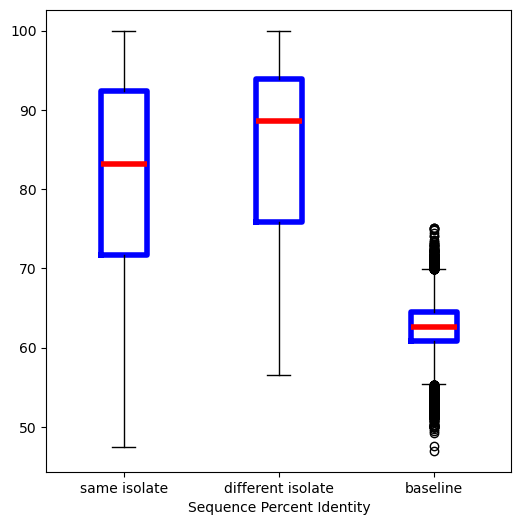

426
69.88 89 20.89
64.46 26 6.1
62.64 11 2.58
60.82 6 1.41
55.37 1 0.23
1189
69.88 175 14.72
64.46 42 3.53
62.64 15 1.26
60.82 10 0.84
55.37 0 0.0


In [43]:
same_cassette_minifam_visual(mfsamecass,[d['id'] for d in baseline[:]])

In [44]:
records=low_conservation_cassettes(mfsamecass,mfsamecassdict,mini_dict,cutoff=69.88)

149 44


In [45]:
def output_highly_homologous(diffsmf):
    same=[record for gf in diffsmf for record in diffsmf[gf] 
          if record[0].split('_')[0]==record[1].split('_')[0] and record[2]>90 and record[2]<=95]
    #different isolate
    diff=[record for gf in diffsmf for record in diffsmf[gf] 
          if record[0].split('_')[0]!=record[1].split('_')[0] and record[2]>90 and record[2]<=95]
    return(same,diff)

output_highly_homologous(diffsmf)

([('Kapeya_mO_074_I', 'Kapeya_mO_090_I', 92.25),
  ('Kapeya_mO_090_I', 'Kapeya_mO_091_I', 93.57),
  ('Kapeya_mO_014_I', 'Kapeya_mO_243_I', 94.41)],
 [('IL3000_mO_172_III', 'Kapeya_mO_226_III', 90.85),
  ('IL3000_mO_028_III', 'Kapeya_mO_058_III', 90.78),
  ('Kapeya_mO_090_I', 'UPKZN_mO_093_I', 90.91),
  ('IL3000_mO_113_III', 'Kapeya_mO_237_III', 90.28)])

In [46]:
output_gfam_minicircle(mini_dict,gRNA_dict,'IL3000_mO_177') #
output_gfam_minicircle(mini_dict,gRNA_dict,'Kapeya_mO_014') #
output_gfam_minicircle(mini_dict,gRNA_dict,'IL3000_mO_076')
output_gfam_minicircle(mini_dict,gRNA_dict,'Kapeya_mO_243')
output_gfam_minicircle(mini_dict,gRNA_dict,'UPKZN_mO_046')
output_gfam_minicircle(mini_dict,gRNA_dict,'UPKZN_mO_158')
output_gfam_minicircle(mini_dict,gRNA_dict,'UPKZN_mO_324')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['Kapeya']['Kapeya_mO_014_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_III']['seq'])
print('############')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['IL3000']['IL3000_mO_076_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['IL3000']['IL3000_mO_076_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['IL3000']['IL3000_mO_076_III']['seq'])
print('############')
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_014_I']['seq'],cassdict['Kapeya']['Kapeya_mO_243_I']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_014_II']['seq'],cassdict['Kapeya']['Kapeya_mO_243_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_014_III']['seq'],cassdict['Kapeya']['Kapeya_mO_243_III']['seq'])
print('############')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['Kapeya']['Kapeya_mO_243_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['Kapeya']['Kapeya_mO_243_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['Kapeya']['Kapeya_mO_243_III']['seq'])
print('############UPKZN_mO_158')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['UPKZN']['UPKZN_mO_158_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['UPKZN']['UPKZN_mO_158_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['UPKZN']['UPKZN_mO_158_III']['seq'])
print('############UPKZN_mO324')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['UPKZN']['UPKZN_mO_324_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['UPKZN']['UPKZN_mO_324_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['UPKZN']['UPKZN_mO_324_III']['seq'])
print('############UPKZN_mO_046')
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_I']['seq'],cassdict['Kapeya']['Kapeya_mO_046_I']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_II']['seq'],cassdict['Kapeya']['Kapeya_mO_046_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_177_III']['seq'],cassdict['Kapeya']['Kapeya_mO_046_III']['seq'])
print('########check COX3-83_115')
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_005_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_099_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_120_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_150_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_154_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_186_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_201_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_212_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_037_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_064_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_160_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_160_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['IL3000']['IL3000_mO_160_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['UPKZN']['UPKZN_mO_032_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['UPKZN']['UPKZN_mO_075_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['UPKZN']['UPKZN_mO_198_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['UPKZN']['UPKZN_mO_270_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
return_cassette_seq_id(cassdict['UPKZN']['UPKZN_mO_318_I']['seq'],cassdict['Kapeya']['Kapeya_mO_014_II']['seq'])
print('########')
return_cassette_seq_id(cassdict['Kapeya']['Kapeya_mO_236_III']['seq'],cassdict['Kapeya']['Kapeya_mO_014_III']['seq'])


{'I': ['ND9-87_104'], 'II': ['ND9-209_226'], 'III': ['ND7-145_170'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['COX3-83_115'], 'III': ['ND8-480_498'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['ND9-209_226'], 'III': ['ND7-145_170'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['ND9-209_226'], 'III': ['ND7-145_170'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['CR4-401_415', 'A6_v1-296_314', 'A6_v2-296_314'], 'III': ['ND7-623_643'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['ND9-209_226'], 'III': ['ND7-145_170'], 'Orphan': []}
{'I': ['ND9-87_104'], 'II': ['ND9-209_226'], 'III': ['ND7-145_170'], 'Orphan': []}
95.77
61.4
60.59
############
69.14
63.69
74.05
############
94.41
61.27
60.23
############
94.41
93.75
95.0
############UPKZN_mO_158
70.19
64.29
74.05
############UPKZN_mO324
91.1
94.41
95.68
############UPKZN_mO_046
60.47
61.4
60.23
########check COX3-83_115
61.76
67.27
68.29
66.67
62.72
56.17
66.27
60.47
63.69
63.69
62.21
62.21
62.21
64.29
67.07
61.27
65.87
69.57
########
70.19


In [105]:
#detection of recombination: sharing at least one/two gRNA families and one different
def identify_pairs_similar_mf(mini_families,shared=1,diff=1):
    records,ts=[],{}
    for i,pair in enumerate(combinations(mini_families.keys(),2)):
        k1,k2=pair[0],pair[1]
        #0=empty cassette, 1=homologous cassette, 2=diffeent cassette
        test=[0 if len(c1)==0 or len(c2)==0 else 1 if c1.issubset(c2) or c2.issubset(c1) else 2 
              for c1,c2 in zip(mini_families[k1]['cassettes'].values(),mini_families[k2]['cassettes'].values())]
        ts[i]=test[:3]
        if ts[i].count(1)>=shared and ts[i].count(2)>=diff:
            records.append({k1:mini_families[k1],k2:mini_families[k2],'hits':ts[i]})
            #print(mini_families[k1]['cassettes'].values(),'\n',mini_families[k2]['cassettes'].values(),test)
    total,allpairs,counts=0,list(ts.keys()),[]
    for i in [0,1,2,3]:
        for j in [0,1,2,3]:
            a=[k for k,test in ts.items() if test.count(1)==i and test.count(2)==j]
            print(i,j,len(a),round(len(a)/88831*100,2))
            total+=len(a)
            counts.append(len(a))
    print(total)
    return(records,counts)
    
def identiy_pairs_similar_mini(mfpairs,cassdict):
    minipairs=[]
    for record in mfpairs:
        k1,k2=list(record.keys())[0],list(record.keys())[1]
        mini1,mini2=record[k1]['population'],record[k2]['population']
        for m1 in mini1:
            isolate1=m1.split('_')[0]
            cassettes1=[cassdict[isolate1][f"{m1}_{c}"] 
                        for c,sets in record[k1]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
            for m2 in mini2:
                isolate2=m2.split('_')[0]
                cassettes2=[cassdict[isolate2][f"{m2}_{c}"] 
                        for c,sets in record[k2]['cassettes'].items() if len(sets)!=0 and c!='Orphan']
                cassid={}
                for i,j in zip(cassettes1,cassettes2):
                    seq1=i['seq']
                    seq2=j['seq']
                    aligner = Align.PairwiseAligner()
                    seq1,seq2 = aligner.align(seq1,seq2)[0]
                    seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                    cassid[i['cassette_label']]=seqid                  
                minipairs.append({'m1':m1,'m2':m2,'cassettes_id':cassid,'mf1':k1,'mf2':k2,'hits':record['hits']})
    return(minipairs)
#filter pairs of minicircles
def filter_pairs_similar_mini(minipairs,cut=69.88):
    #part 1 visualize the sequence identity in shared vs distinct cassettes
    def visual(minipairs):
        shared=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),pair['hits']) if hit==1]
        diff=[iden for pair in minipairs for iden,hit in zip(pair['cassettes_id'].values(),pair['hits']) if hit==2]
        a=ttest_ind(shared, diff)
        print(round(sum(shared)/len(shared),2),round(sum(diff)/len(diff),2),a.pvalue)
        data=[shared,diff]
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
        boxprops = dict(linestyle='-', linewidth=4, color='b')
        medianprops = dict(linestyle='-', linewidth=4, color='r')
        labels=['same gRNA family','distinct gRNA family']
        bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
        ax.set_ylabel('SID (%)')
    visual(minipairs)
    def cutoff_stats():
        cutoffs=[69.88,64.46,62.64,60.82,55.37]
        for cutoff in cutoffs:
            tmp=[1 for pair in minipairs 
                 if sum([1 if hit==1 and iden<cutoff else 0 for iden,hit in zip(pair['cassettes_id'].values(),pair['hits'])])==0]
            print(cutoff,len(tmp))
    #cutoff_stats()
    def stats(filtered):
        mf=set([pair['mf1'] for pair in filtered]+[pair['mf2'] for pair in filtered])
        print('number of minicircle families',len(mf))
        mf=set([pair['m1'] for pair in filtered]+[pair['m2'] for pair in filtered])
        print('number of minicircles',len(mf))
    filtered1=[pair for pair in minipairs 
             if sum([1 if hit==1 and iden<cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),pair['hits'])])==0]
    stats(filtered1)
    filtered2=[pair for pair in filtered1 
             if sum([1 if hit==2 and iden>cut else 0 for iden,hit in zip(pair['cassettes_id'].values(),pair['hits'])])==0]
    stats(filtered2)
    visual(filtered2)
    return (filtered2)
def identiy_donor_mini(filtered2,mini_dict,mini_families,cassdict,cutoff=69.88):
    candidate_donors,test={},[]
    for record in filtered2:
        c=[k for k,v in record['cassettes_id'].items() if v<cutoff][0]
        s1,s2=record['m1'].split('_')[0],record['m2'].split('_')[0]
        m1,m2=record['m1'],record['m2']
        seq1,seq2=cassdict[s1][f'{m1}_{c}']['seq'],cassdict[s2][f'{m2}_{c}']['seq']
        mf1,mf2=mini_dict[m1]['family'][0],mini_dict[m2]['family'][0]
        gf1,gf2=set(mini_families[mf1]['cassettes'][c]),set(mini_families[mf2]['cassettes'][c])
        donor1=[(v['population'],cas) for cas in ['I','II','III'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf1))!=0]
        donor2=[(v['population'],cas) for cas in ['I','II','III'] for k,v in mini_families.items() if len(set(v['cassettes'][cas]).intersection(gf2))!=0]
        def filter_donors(seq,order,cass,donors,cassdict):
            tmp={'order':order}
            for record in donors:
                c=record[1]
                for donor in record[0]:
                    if f'{donor}_{c}' != cass:
                        donor_seq=cassdict[donor.split('_')[0]][f'{donor}_{c}']['seq']
                        aligner = Align.PairwiseAligner()
                        seq1,seq2 = aligner.align(seq,donor_seq)[0]
                        seqid=round(sum([1 for i,j in zip(seq1,seq2) if i==j])/len(seq1)*100,2)
                        tmp[f'{donor}_{c}']=seqid
            return(tmp)
        candidate_donors[f'{m1}_{c}']=filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict)
        candidate_donors[f'{m2}_{c}']=filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict)
        #test.append(filter_donors(seq1,1,f'{m1}_{c}',donor1,cassdict))
        #test.append(filter_donors(seq2,2,f'{m2}_{c}',donor2,cassdict))
        #print(gf2,donor1)
    return(candidate_donors)



In [48]:
#find pairs of minicircle families
mfpairs,counts=identify_pairs_similar_mf(mini_families,shared=2,diff=1)
len(mfpairs)

0 0 2626 2.96
0 1 21489 24.19
0 2 38449 43.28
0 3 23719 26.7
1 0 297 0.33
1 1 1131 1.27
1 2 886 1.0
1 3 0 0.0
2 0 86 0.1
2 1 121 0.14
2 2 0 0.0
2 3 0 0.0
3 0 27 0.03
3 1 0 0.0
3 2 0 0.0
3 3 0 0.0
88831


121

In [49]:
#find pairs of minicircles
minipairs=identiy_pairs_similar_mini(mfpairs,cassdict)
print(len(minipairs))

333


68.73 63.06 6.931328946607671e-61
number of minicircle families 59
number of minicircles 83
number of minicircle families 53
number of minicircles 75
74.34 62.62 4.241661123761551e-42
total pairs 64, minicircle from the same isolate: 19,
minicircle from different isolates: 45


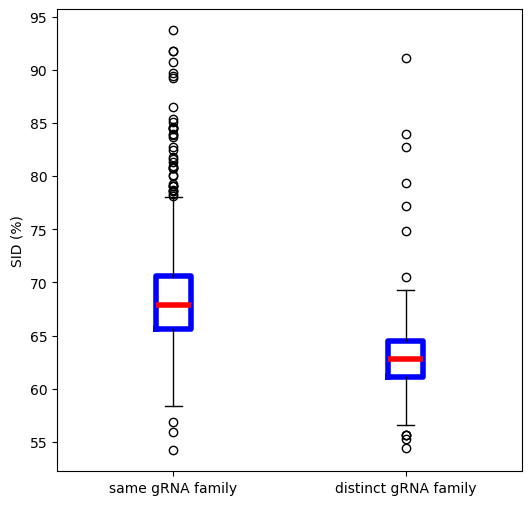

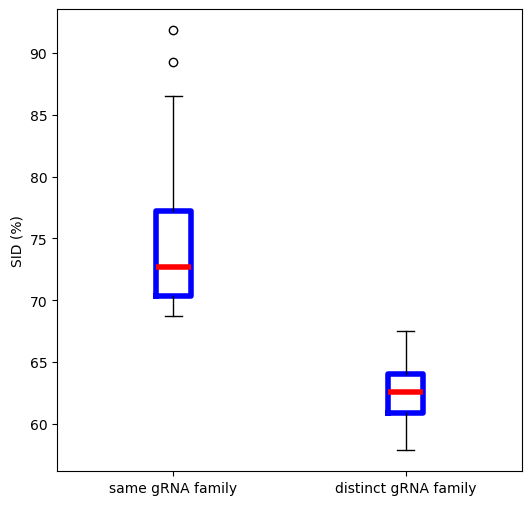

In [113]:
#analysis of minipairs
filtered2=filter_pairs_similar_mini(minipairs,cut=68.75)
#filtered2
total=len(filtered2)
sameisolate=[pair for pair in filtered2 if pair['m1'].split('_')[0]==pair['m2'].split('_')[0]]
diffisolate=[pair for pair in filtered2 if pair['m1'].split('_')[0]!=pair['m2'].split('_')[0]]
print(f"total pairs {total}, minicircle from the same isolate: {len(sameisolate)},\nminicircle from different isolates: {len(diffisolate)}")

In [110]:
def output_filtered(filtered, mini_families,outfile):
    outdict={i:{} for i,p in enumerate(filtered)}
    for i,v in enumerate(filtered):
        outdict[i]['m1'],outdict[i]['m2']=v['m1'],v['m2']
        for c,sid in v['cassettes_id'].items():
            #if mini_families[v['mf1']]['cassettes'][c]==mini_families[v['mf2']]['cassettes'][c]:
            #    outdict[i][c]=f"{','.join(mini_families[v['mf1']]['cassettes'][c])}: {sid}%"
            #else:
            #    outdict[i][c]=f"{','.join(mini_families[v['mf1']]['cassettes'][c])}/{','.join(mini_families[v['mf2']]['cassettes'][c])}: {sid}%"
            outdict[i][c]=sid
    df=pd.DataFrame.from_dict(outdict,orient='index')
    df.to_csv(outfile)
    return(outdict)
outfile=f'/home/jovyan//Tcongo_PacBio/Tcongo_recombination_pairs.csv'
outdict=output_filtered(filtered2, mini_families,outfile)

In [51]:
candidate_donors=identiy_donor_mini(filtered2,mini_dict,mini_families,cassdict,cutoff=69.88)

In [52]:
print(len(candidate_donors))
cutoff=69.88
hqdonors={k:{d:iden for d,iden in v.items() if iden >=cutoff} for k,v in candidate_donors.items() }
hqdonors={k:v for k,v in hqdonors.items() if len(v)!=0}
print('cass with candidate donors',len(hqdonors))
multidonors=[k for k,v in hqdonors.items() if len(v)>1]
print('cass with multiple donors',len(multidonors))
topdonors={k:{d:iden for d,iden in v.items() if iden == max(list(v.values()))} for k,v in hqdonors.items()}
topdonorid=[iden for v in topdonors.values() for iden in v.values()]
print(max(topdonorid),min(topdonorid),sum(topdonorid)/len(topdonorid))
highlysimilardonor={k:{d:iden for d,iden in v.items() if iden >95} for k,v in hqdonors.items()}

56
cass with candidate donors 55
cass with multiple donors 50
98.55 70.55 84.84758620689655


5.600976875819692e-59 98.55 73.89 58.72 1


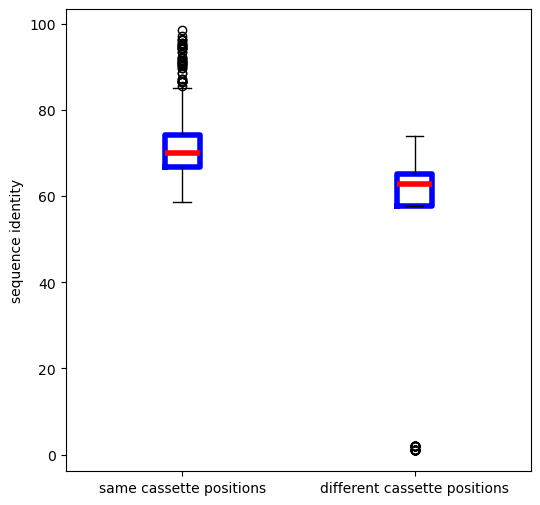

{'IL3000_mO_015_III': 1, 'IL3000_mO_160_II': 2} 1.443678115978291e-20


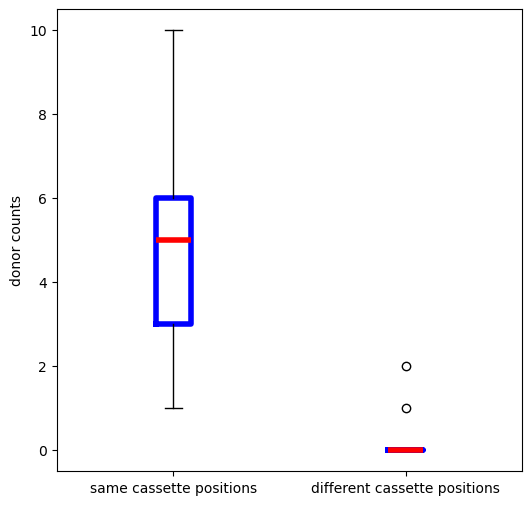

In [53]:
#donor biased towards the same cassette position
def donor_similarity(candidate_donors):
    same=[s for k,v in candidate_donors.items() for d,s in v.items() if d.split('_')[-1]==k.split('_')[-1]]
    diff=[s for k,v in candidate_donors.items() for d,s in v.items() if d.split('_')[-1]!=k.split('_')[-1]]
    a=ttest_ind(same, diff)
    print(a.pvalue,max(same),max(diff),min(same),min(diff))
    data=[same,diff]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['same cassette positions','different cassette positions']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('sequence identity')
    plt.show()
def cassette_position_bias(hqdonors):
    same={k:len([d for d in v.keys() if d.split('_')[-1]==k.split('_')[-1]]) for k,v in hqdonors.items()}
    diff={k:len([d for d in v.keys() if d.split('_')[-1]!=k.split('_')[-1]]) for k,v in hqdonors.items()}
    a=ttest_rel(list(same.values()), list(diff.values()))
    print({k:v for k,v in diff.items() if v!=0},a.pvalue)
    data=[list(same.values()), list(diff.values())]
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6), sharey=False)
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    labels=['same cassette positions','different cassette positions']
    bp=ax.boxplot(data,labels=labels,vert=True,boxprops=boxprops,medianprops=medianprops)
    ax.set_ylabel('donor counts')
    plt.show()

donor_similarity(candidate_donors)
cassette_position_bias(hqdonors)

[  0   2 101 195  10]


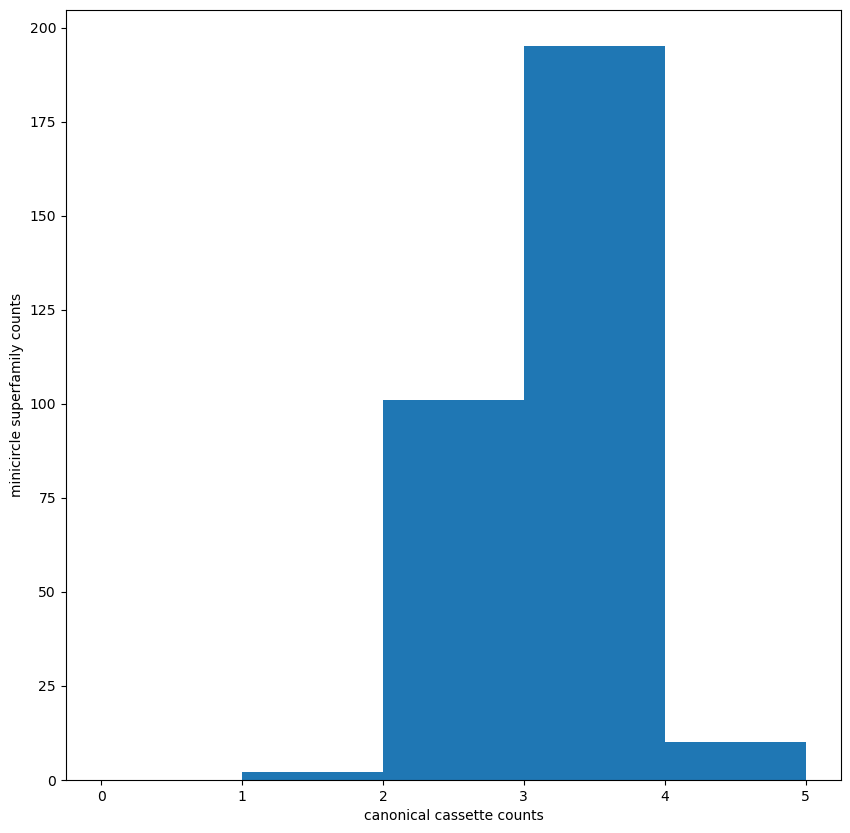

In [57]:
def canonical_cassette_counts(superf):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    #number of minicircle families
    data=[len([1 for i in v['cassettes'].values() if i!=set()]) for smf, v in superf.items()] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(counts)
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle superfamily counts')
    ax.set_xlabel('canonical cassette counts')

canonical_cassette_counts(superfam1)

In [58]:
#get superf of a mf

def search_smf_for_mf(mf,superf):
    out={k:v for k,v in superf.items() if mf in v['population']}
    print(out)
def output_cassette_of_smf(smf,superfam2,mini_dict,gRNA_dict):
    for m in superfam2[smf]['population']:
        out={k:[gRNA_dict[g]['gRNA_family'] for g in v] for k,v in mini_dict[m].items()}
        print(m,out)

        
search_smf_for_mf('mf408',superfam1)

{'smf225': {'cassettes': {'I': set(), 'II': {'RPS12-54_70'}, 'III': {'COX3-972_987'}, 'Orphan': set()}, 'population': ['mf248', 'mf408']}}


In [59]:
sfout=f"{outdir}/superfamily.csv"
df=pd.DataFrame.from_dict(superfam1, orient='index')
df.to_csv(sfout)

In [60]:
def output_cassettes_of_gfamily(gf,gfam,gRNA_dict):
    cs={g:(gRNA_dict[g]['cassette_label'],gRNA_dict[g]['gRNA_seq']) for g in gfam[gf]['gRNA']}
    print(cs)
gRNA_dict['IL3000_gRNA_67']
mini_dict['Kapeya_mO_218']
output_cassettes_of_gfamily('COX3-83_115',gfam,gRNA_dict)

{'IL3000_gRNA_115': ('III', 'UGUUACAGAGAUAAGAGAGUGGGAAUGGCAGAUAAC'), 'IL3000_gRNA_211': ('III', 'UGUUACAGAGAUGAGAGAAUGGGAAUGGCAGAUAACAAUAA'), 'IL3000_gRNA_524': ('III', 'UAAUUGUUACGAGAGCAGAGAAUUAGAGAUGGUGGAUAGCAAUAACAUA'), 'Kapeya_gRNA_13': ('III', 'UACAAUUGUUACAGAGAUAAGGGAACGGAAGUGAUAGAUAACAAUAA'), 'Kapeya_gRNA_40': ('II', 'UAAUUGCCAUGGAGACAGAGAAACAGAUAGGGCAGAUAACAAUAA'), 'Kapeya_gRNA_327': ('III', 'UAAUUGUUACGAGAAUAGAAGGAUAGAGAUGGCAGAUAACAAUA'), 'Kapeya_gRNA_392': ('III', 'ACAGAGAUAAGGGAACAUAAAUGGCAGAUAACAAUA'), 'Kapeya_gRNA_492': ('III', 'UAAUUGUUACGAGAACAGAGAAACAGA'), 'Kapeya_gRNA_505': ('III', 'AGUGAGAGAGGCGGGUGACAAUAACAUAUAA'), 'Kapeya_gRNA_589': ('III', 'UAAUUGUUACGAGAGUGGAGAAUCAGAGAUGGUAGAUAA'), 'Kapeya_gRNA_642': ('III', 'UGUUACAGAGAUAAAAGAACAUAGAUGGCAGAUAACAAUAA'), 'Kapeya_gRNA_675': ('III', 'GUGGCAGAUAACAAUAACAUAUAA'), 'UPKZN_gRNA_98': ('III', 'UAAUUGUUACGAGAAUAGAAGGAUAGAGAUGGUAGGUAACAAUA'), 'UPKZN_gRNA_231': ('III', 'UAAUUGCUAUAGGAACAGAUGGGUAGAGAUGGCUGAUAACAAUAA'), 'UPKZN_g

{1: 0, 2: 0, 3: 0, 4: 422}
237


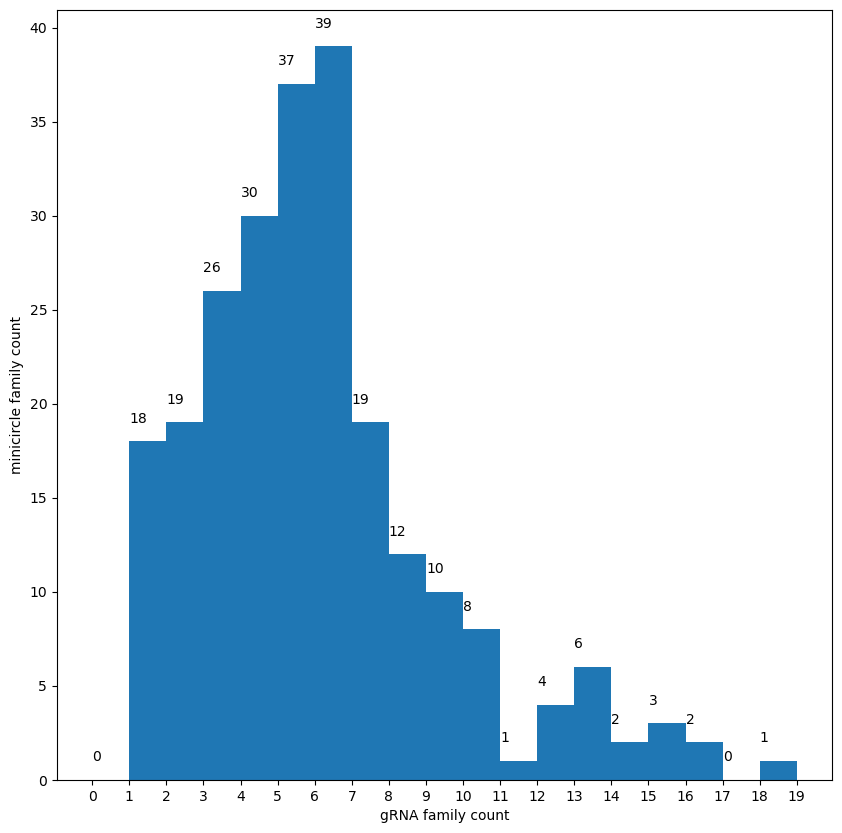

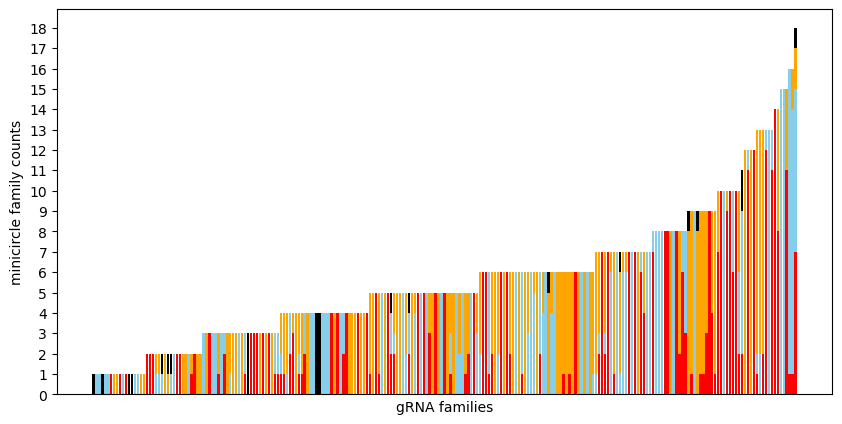

In [61]:
def minicircle_family_stats(mini_families):
    #number of gf
    data=[len([c for c,gf in v['cassettes'].items() if gf!=[]]) for mf,v in mini_families.items()]
    data={k:data.count(k) for k in [1,2,3,4]}
    print(data)
def gRNA_family_stats_with_mfam1(gfam):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10), sharey=False)
    #number of minicircle families
    data=[len(gfv['minicircle_family']) for gf,gfv in gfam.items() if gf != 'ND7-1241_1252'] #maxicircle gRNA
    bins=range(0,max(data)+2,1)
    counts, bins = np.histogram(data,bins=bins)
    print(sum(counts))
    ax.hist(data,bins=bins)
    ax.set_xticks(bins)
    ax.set_ylabel('minicircle family count')
    ax.set_xlabel('gRNA family count')
    for i,j in zip(bins,counts):
        ax.text(i,j+1,j)
    plt.show()
def gRNA_family_stats_with_mfam2(gfam):
    #number of minicircle families and show cassette positions
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 5), sharey=False)
    cs=['I','II','III','Orphan']
    cass={gf: {c: list(v['minicircle_family'].values()).count(c) for c in cs} for gf,v in gfam.items() if gf != 'ND7-1241_1252'}
    cass={k:v for k,v in sorted(cass.items(), key=lambda item: sum(item[1].values()))}
    df=pd.DataFrame.from_dict(cass, orient='index')
    ax.bar(df.index, (df['I']), label='I',color='r')
    ax.bar(df.index, (df['II']),bottom=(df['I']),label='II',color='skyblue')
    ax.bar(df.index, (df['III']),bottom=(df['I']+df['II']),label='III',color='orange')
    ax.bar(df.index, (df['Orphan']),bottom=(df['I']+df['II']+df['III']),label='Orphan',color='black')
    ax.set_xticks([])
    ax.set_yticks(range(19))
    ax.set_xlabel('gRNA families')
    ax.set_ylabel('minicircle family counts')
    plt.show()


    
#execution 
minicircle_family_stats(mini_families)
gRNA_family_stats_with_mfam1(gfam)
gRNA_family_stats_with_mfam2(gfam)

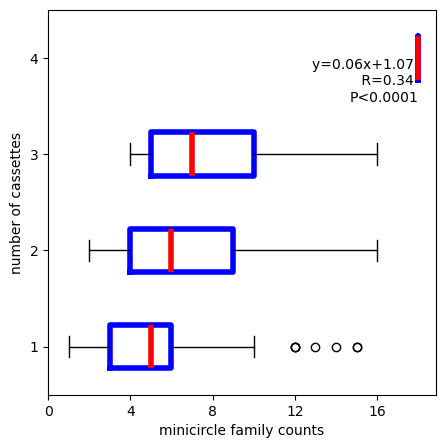

In [62]:
def gRNA_family_stats_with_mfam2_1(gfam):#correlation
    #number of minicircle families and show cassette positions
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), sharey=False)
    cs=['I','II','III','Orphan']
    cass={gf: {c: list(v['minicircle_family'].values()).count(c) for c in cs} for gf,v in gfam.items() if gf != 'ND7-1241_1252'}
    cass={k:v for k,v in sorted(cass.items(), key=lambda item: sum(item[1].values()))}
    x=[sum(v.values()) for v in cass.values()]
    y=[sum([1 for i in v.values() if i!=0]) for v in cass.values()]
    boxprops = dict(linestyle='-', linewidth=4, color='b')
    medianprops = dict(linestyle='-', linewidth=4, color='r')
    data,counts=[],[1,2,3,4]
    for i in counts:
        data.append([a for a,b in zip(x,y) if b==i])
    ax.boxplot(data,labels=counts,vert=False,boxprops=boxprops,medianprops=medianprops)
    ax.set_xlabel('minicircle family counts')
    ax.set_ylabel('number of cassettes')
    ax.set_xticks(range(0,20,4))
    corr=linregress(x, y)
    if round(corr.pvalue,5)==0:
        p='P<0.0001'
    else:
        p=f"P={round(corr.pvalue,5)}"
    ax.text(max(x),max(y),f"y={round(corr.slope,2)}x+{round(corr.intercept,2)} \n R={round(corr.rvalue,2)} \n{p}",ha='right',va='top')
    plt.show()

gRNA_family_stats_with_mfam2_1(gfam)

IL3000 155
Kapeya 211
UPKZN 260


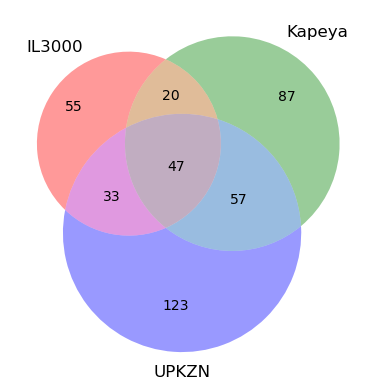

In [65]:
def shared_mini(mini_families,strains=['IL3000','Kapeya','UPKZN']):
    def get_mfam(mini_families,strain):
        mfam=set([k for k,v in mini_families.items() if strain in [m.split('_')[0] for m in v['population']]])
        print(strain,len(mfam))
        return(mfam)
    venn3([get_mfam(mini_families,strain) for strain in strains], strains)
    plt.show()

shared_mini(mini_families,strains=['IL3000','Kapeya','UPKZN'])

In [66]:
123/260

0.47307692307692306

In [67]:
for mrna in gRNA_families:
    for gf in gRNA_families[mrna]:
        rightmost=[int(gRNA_dict[g]['mRNA_end'])-6 for g in gRNA_families[mrna][gf]['gRNA']]
        leftmost=[int(gRNA_dict[g]['mRNA_start']) for g in gRNA_families[mrna][gf]['gRNA']]
        gRNA_families[mrna][gf]['editing_range']=(min(leftmost),max(rightmost)-6)
gfam={gf:record for m,v in gRNA_families.items() for gf,record in v.items()}


In [68]:
print(f"{len(mini_dict)} out of 767 minicircles are annotated, giving {len(gfam)} gRNA families and {len(mini_families)} mini families" )

754 out of 767 minicircles are annotated, giving 238 gRNA families and 422 mini families


#check if gRNA family is essential
#the code is poorly designed, but probably not needed either
def check_essential(gRNA_families,insertions):
    def calculate_gap(gRNA_families2,insertions,mrna,omit='False'):
        edits={mrna:[0 if i==1 else 1 for i in insertions[mrna]] for mrna in insertions}#1 for u insertions
        for gf in gRNA_families2[mrna]:
            if gf!=omit:
                coverage=gRNA_families2[mrna][gf]['editing_range']
                for i in range(coverage[0],min(coverage[1],len(edits[mrna]))):
                    edits[mrna][i]=0 #set insertions to 0
        return(sum(edits[mrna]))
    for mrna in gRNA_families:
        total_gaps=calculate_gap(gRNA_families2,insertions,mrna,omit='False')
        for gf in gRNA_families[mrna]:
            gaps=calculate_gap(gRNA_families2,insertions,mrna,omit=gf)
            if gaps>total_gaps:
                print(f"{gf} is essential")
                #continue
            else:
                #print(f"{gf} is not essential")
                continue
        print(mrna,total_gaps)
            
check_essential(gRNA_families,insertions)

filename=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/gRNA_fam_divisions_{strain}.pdf'
plot_initiation_sites(inits,gRNA_families2,gRNA_dict2,combined,filename,figw=100,figh=100)

          I   II  III  IV  V  Orphan
A6_v1    73   75  102   0  0       3
A6_v2    70   69   99   0  0       3
COX3    206  144  145   0  0       4
CR3       0   48   24   0  0       1
CR4      21   73   50   0  0       2
CYB       0    0    0   0  0      16
ND3_v1   37   65   39   0  0       2
ND3_v2   28   65   32   0  0       1
ND7     180   75  168   0  0       1
ND8      39   43   61   0  0       8
ND9      61   48   70   0  0       0
RPS12    19   29   42   0  0       0


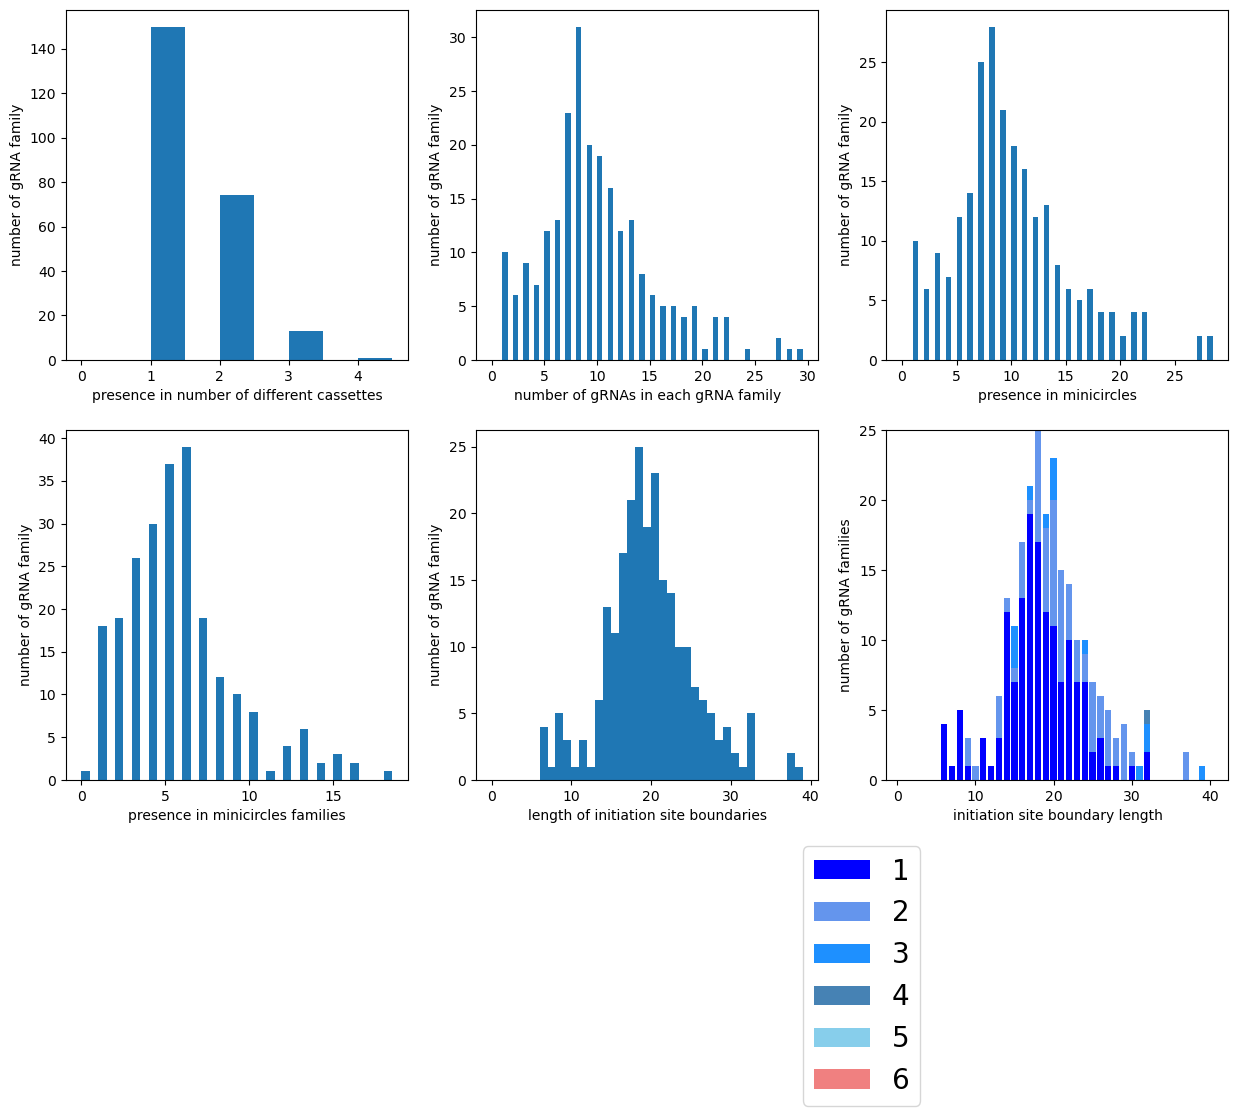

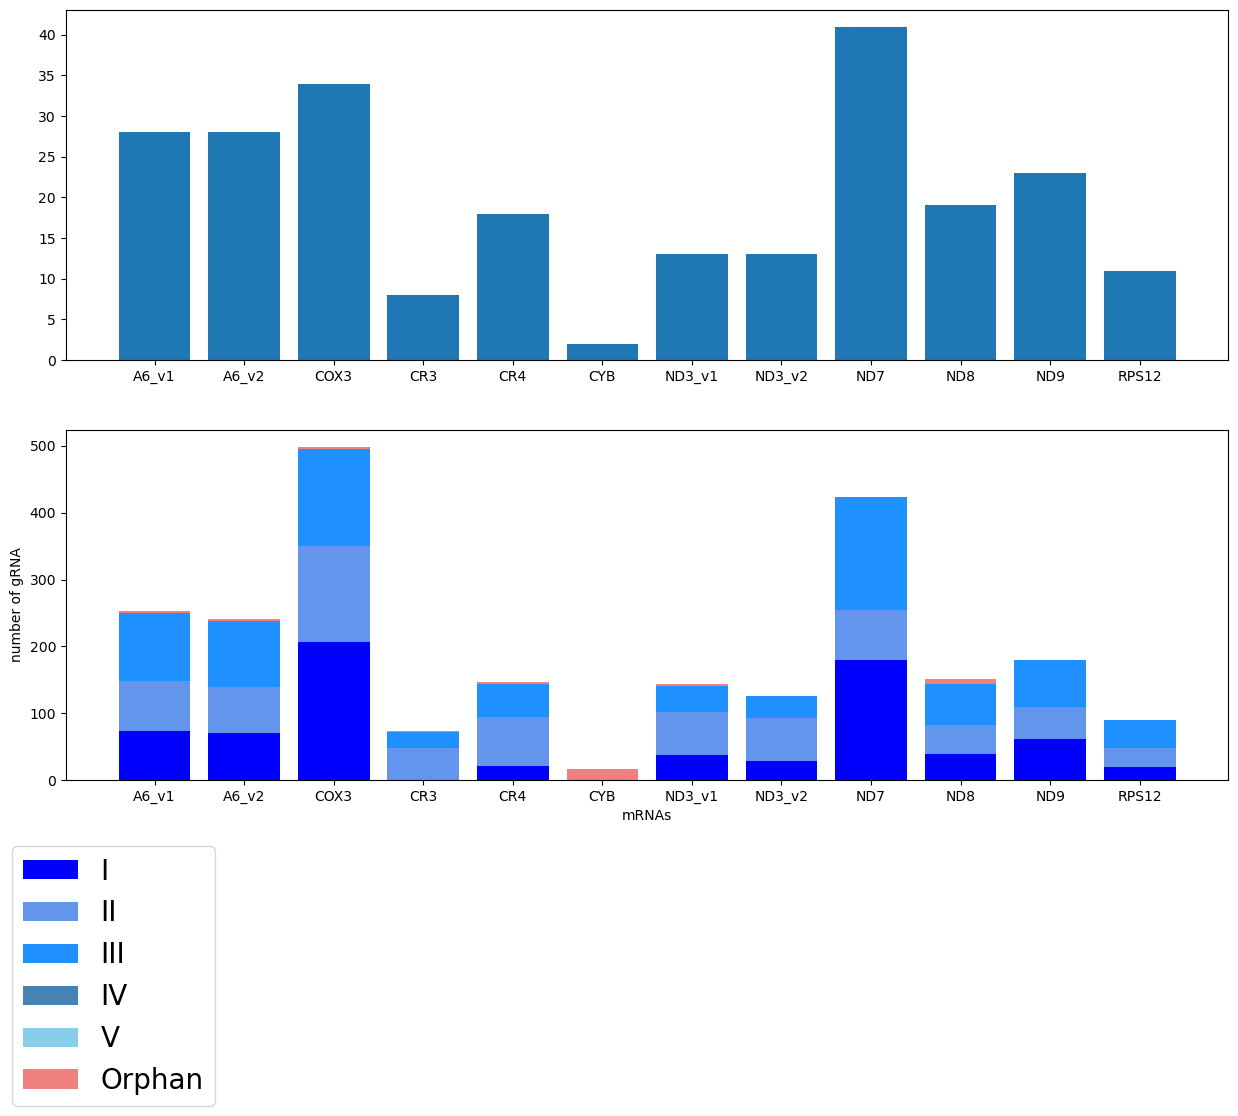

In [69]:
gRNA_family_stats(gRNA_dict,gRNA_families,figw=15,figh=10) #add 'cassette' to gRNA_families2

In [70]:
#output_gRNA_families(gRNA_families2,gRNA_dict2,threshold=3)
connections,shared,renamed_mini_family=connect_mini(mini_dict,mini_families)

In [71]:
#detect similar minicircles:
##if contains or is the subset of another minicircle family
##if no mismatches
##if shares >1 gRNA family and has <=1 mismatch
#if share 1 gRNA family and has <=1 mismatch
#connections,shared,renamed_mini_family=connect_mini(mini_dict,mini_families)
#turns out sharing 3 gFam at most
#output a xls file for searching minicircle families
csv_out=f'/home/jovyan/Minicircle_gRNA_families/Work_files/{strain}/minicircle_families.csv'
tmp={k:{c:v for c,v in zip(cassettes,renamed_mini_family[k]['cassettes'].split(';'))} for k in renamed_mini_family}
df=pd.DataFrame.from_dict(tmp,orient='index')
df.to_csv(csv_out)

#plot network for individual gRNA family and minicircle family
date = datetime.datetime.now().strftime("%Y-%m-%d")
for gf in gfam:
    out=f'{outdir}/Mini_fam_network_per_gRNA_fam/{strain}_{gf}.pdf'
    G=selected_g_m_family_network(gRNA_families,renamed_mini_family,gRNA_dict,[gf],colors=colors)
    plot_network(out, G)

In [74]:
#renamed_mini_family

In [73]:
#visualize using different conditions
#plot network by the number of shared vs different gRNA families
for mindiff in [-1,0,1]:
    MS= visulize_mini_shared(shared,renamed_mini_family,mindiff=mindiff)
    plot_network(f'{outdir}/{strain}_shared_{mindiff}_{date}.pdf', MS)

Disconnected minicircle families (422):
['mFam_0', 'mFam_1', 'mFam_2', 'mFam_3', 'mFam_4', 'mFam_5', 'mFam_6', 'mFam_7', 'mFam_8', 'mFam_9', 'mFam_10', 'mFam_11', 'mFam_12', 'mFam_13', 'mFam_14', 'mFam_15', 'mFam_16', 'mFam_17', 'mFam_18', 'mFam_19', 'mFam_20', 'mFam_21', 'mFam_22', 'mFam_23', 'mFam_24', 'mFam_25', 'mFam_26', 'mFam_27', 'mFam_28', 'mFam_29', 'mFam_30', 'mFam_31', 'mFam_32', 'mFam_33', 'mFam_34', 'mFam_35', 'mFam_36', 'mFam_37', 'mFam_38', 'mFam_39', 'mFam_40', 'mFam_41', 'mFam_42', 'mFam_43', 'mFam_44', 'mFam_45', 'mFam_46', 'mFam_47', 'mFam_48', 'mFam_49', 'mFam_50', 'mFam_51', 'mFam_52', 'mFam_53', 'mFam_54', 'mFam_55', 'mFam_56', 'mFam_57', 'mFam_58', 'mFam_59', 'mFam_60', 'mFam_61', 'mFam_62', 'mFam_63', 'mFam_64', 'mFam_65', 'mFam_66', 'mFam_67', 'mFam_68', 'mFam_69', 'mFam_70', 'mFam_71', 'mFam_72', 'mFam_73', 'mFam_74', 'mFam_75', 'mFam_76', 'mFam_77', 'mFam_78', 'mFam_79', 'mFam_80', 'mFam_81', 'mFam_82', 'mFam_83', 'mFam_84', 'mFam_85', 'mFam_86', 'mFam_87', '